# Milestone 4 Notebook

Members: Siri Pranivong, Chloe Seo, Kaylee Vo, Kai Yeh

## Table of Contents

1. **[Data Overview](#data-overview)**
    - 1.1 [Data Description](#data-description)
    - 1.2 [Data Summary](#data-summary)
        - 1.2.1 [Discrete Variables](#discrete-variables)
        - 1.2.2 [Continuous Variables](#continuous-variables)
        - 1.2.3 [Binary Variables](#binary-variables)
2. **[Exploratory Data Analysis](#exploratory-data-analysis)**
    - 3.1 [Deeper Understanding of the Data](#deeper-understanding-of-the-data)
    - 3.2 [Meaningful Insights](#meaningful-insights)
    - 3.3 [Noteworthy Findings](#noteworthy-findings)
3. **[Research Question](#research-question)**
4. **[Baseline Models](#baseline-models)**
5. **[Prediction Models](#prediction-models)**
6. **[Model Evaluation](#model-evaluation)**
7. **[Causal Inference](#causal-inference)**

### Imports

In [63]:
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

import xgboost as xgb
from xgboost import XGBClassifier

from warnings import simplefilter

from utils.helper import get_variable_category, split_snake_case

# Suppress warnings
simplefilter('ignore', category=UserWarning)  # Ignore 'fit without feature names' warning
simplefilter('ignore', category=FutureWarning)  # Ignore XGBoost warnings

from sklearn import set_config
from IPython.display import display


### Pandas Settings

In [60]:
pd.set_option("display.max_columns", None)

### Notebook Parameters

In [61]:
output_img = False
random_state = 109

## Data Overview

### Data Description

In [62]:
X_train = pd.read_csv("./data/prod/X_train.csv")
y_train = pd.read_csv("./data/prod/y_train.csv")
X_test = pd.read_csv("./data/prod/X_test.csv")
y_test = pd.read_csv("./data/prod/y_test.csv")
data_dictionary = pd.read_csv("./data/raw/data_dictionary.csv")

In [63]:
# Preview the Data
X_train.head()

customer_id  perc_change_minutes  perc_change_revenues  dropped_calls  \
0      3153578                 98.0                   0.2            2.3   
1      3163414                -38.0                  -0.4            3.0   
2      3348322                 13.0                  -0.9            6.3   
3      3269774                  0.0                   0.0            0.0   
4      3283286               -122.0                  -5.5            0.0   

   unanswered_calls  received_calls  months_in_service  unique_subs  \
0               9.7            50.3                 16            1   
1              10.3            95.1                 16            1   
2              10.0             7.2                 10            1   
3               0.0             0.0                 13            1   
4               0.0             0.0                  8            1   

   active_subs  handsets  handset_models  current_equipment_days  age_hh1  \
0            1       1.0             1.0                   501.0     26.0   
1            1       1.0             1.0                   478.0     46.0   
2            1       1.0             1.0                   291.0     58.0   
3            1       1.0             1.0                   384.0      0.0   
4            1       1.0             1.0                   253.0     50.0   

   age_hh2  children_in_hh  handset_refurbished  handset_web_capable  \
0      0.0               0                    0                    1   
1      0.0               0                    0                    1   
2     58.0               0                    0                    1   
3      0.0               0                    0                    1   
4     48.0               1                    0                    1   

   truck_owner  rv_owner  homeownership  buys_via_mail_order  \
0            0         0              1                    0   
1            0         0              1                    1   
2            0         0              1                    1   
3            0         0              0                    0   
4            0         0              1                    1   

   responds_to_mail_offers  opt_out_mailings  non_us_travel  owns_computer  \
0                        0                 0              0              0   
1                        1                 0              0              0   
2                        1                 0              0              1   
3                        0                 0              0              0   
4                        1                 0              1              0   

   has_credit_card  retention_calls  retention_offers_accepted  \
0                0                0                          0   
1                1                0                          0   
2                1                0                          0   
3                0                0                          0   
4                1                0                          0   

   new_cellphone_user  referrals_made_by_subscriber  income_group  \
0                   1                             0             4   
1                   0                             0             8   
2                   0                             0             7   
3                   0                             0             0   
4                   0                             0             1   

   owns_motorcycle  adjustments_to_credit_rating  handset_price  \
0                0                             0       71.06962   
1                0                             0       71.06962   
2                0                             0       71.06962   
3                0                             0       71.06962   
4                0                             0       71.06962   

   made_call_to_retention_team  credit_rating  total_care_issues  \
0                            0              2                2.6   
1                 

In [64]:
# Data size
print("Train Data Dimensions:", X_train.shape)
print(f"Test Data Dimensions:", X_test.shape)
print(
    f"Train Split Size: {round(X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]), 4)}"
)

Train Data Dimensions: (20520, 69)
Test Data Dimensions: (5131, 69)
Train Split Size: 0.8


In [65]:
# Descriptive Statistics
X_train.describe().round(2)

customer_id  perc_change_minutes  perc_change_revenues  dropped_calls  \
count     20520.00             20520.00              20520.00       20520.00   
mean    3192916.70                -7.14                 -0.89           2.42   
std      115677.81                83.30                  3.73           2.87   
min     3000010.00              -329.00                -12.80           0.00   
25%     3091764.00               -45.00                 -1.70           0.30   
50%     3186958.00                -4.00                 -0.20           1.30   
75%     3294300.00                29.00                  0.00           3.70   
max     3399946.00               307.00                 10.20          15.00   

       unanswered_calls  received_calls  months_in_service  unique_subs  \
count          20520.00        20520.00           20520.00     20520.00   
mean              12.23           36.80              19.26         1.57   
std               13.14           48.49               9.58         1.62   
min                0.00            0.00               6.00         1.00   
25%                2.30            1.20              11.00         1.00   
50%                8.00           16.80              17.00         1.00   
75%               17.70           53.92              25.00         2.00   
max               71.70          248.40              60.00       196.00   

       active_subs  handsets  handset_models  current_equipment_days  \
count     20520.00  20520.00        20520.00                20520.00   
mean          1.40      1.50            1.36                  444.75   
std           0.75      0.84            0.64                  260.54   
min           0.00      1.00            1.00                   -4.00   
25%           1.00      1.00            1.00                  260.00   
50%           1.00      1.00            1.00                  386.00   
75%           2.00      2.00            2.00                  604.00   
max          53.00      5.00            5.00                 1554.00   

        age_hh1   age_hh2  children_in_hh  handset_refurbished  \
count  20520.00  20520.00        20520.00             20520.00   
mean      35.86     26.38            0.27                 0.11   
std       23.23     28.70            0.44                 0.32   
min        0.00      0.00            0.00                 0.00   
25%       26.00      0.00            0.00                 0.00   
50%       40.00     28.00            0.00                 0.00   
75%       50.00     46.00            1.00                 0.00   
max      108.03    149.81            1.00                 1.00   

       handset_web_capable  truck_owner  rv_owner  homeownership  \
count             20520.00     20520.00  20520.00       20520.00   
mean                  0.87         0.21      0.09           0.73   
std                   0.34         0.41      0.29           0.45   
min                   0.00         0.00      0.00           0.00   
25%                   1.00         0.00      0.00           0.00   
50%                   1.00         0.00      0.00           1.00   
75%                   1.00         0.00      0.00           1.00   
max                   1.00         1.00      1.00           1.00   

       buys_via_mail_order  responds_to_mail_offers  opt_out_mailings  \
count             20520.00                 20520.00          20520.00   
mean                  0.42                     0.44              0.02   
std                   0.49                     0.50              0.14   
min                   0.00                     0.00              0.00   
25%                   0.00                     0.00              0.00   
50%                   0.00                     0.00              0.00   
75%                   1.00                     1.00              0.00   
max                   1.00                     1.00              1.00   

       non_us_travel  owns_computer  has_credit_card  retention_calls  \
count       20520.00  

In [66]:
# Data Types and missingness
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20520 entries, 0 to 20519
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   customer_id                           20520 non-null  int64  
 1   perc_change_minutes                   20520 non-null  float64
 2   perc_change_revenues                  20520 non-null  float64
 3   dropped_calls                         20520 non-null  float64
 4   unanswered_calls                      20520 non-null  float64
 5   received_calls                        20520 non-null  float64
 6   months_in_service                     20520 non-null  int64  
 7   unique_subs                           20520 non-null  int64  
 8   active_subs                           20520 non-null  int64  
 9   handsets                              20520 non-null  float64
 10  handset_models                        20520 non-null  float64
 11  current_equipme

In [67]:
# No. Of missing vablues per variable
X_train.isnull().sum()

customer_id                          0
perc_change_minutes                  0
perc_change_revenues                 0
dropped_calls                        0
unanswered_calls                     0
                                    ..
age_hh2_is_zero                      0
total_care_issues_is_zero            0
value_added_service_usage_is_zero    0
total_calls_is_zero                  0
total_peak_off_peak_calls_is_zero    0
Length: 69, dtype: int64

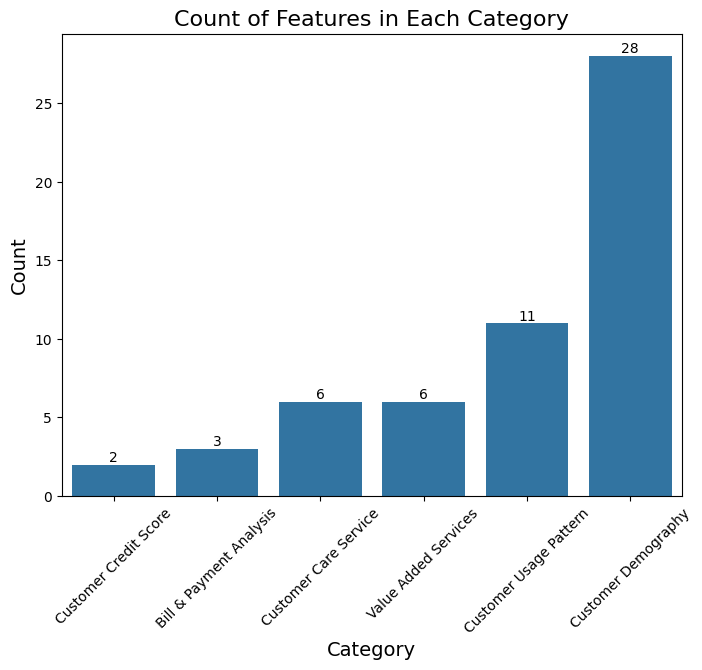

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_data = data_dictionary[
    ~data_dictionary["Category"].isin(["Customer ID", "Response Variable"])
]
_ = sns.countplot(
    x="Category",
    data=plot_data,
    order=plot_data["Category"].value_counts(ascending=True).index,
)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )
ax.set_title("Count of Features in Each Category", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Category", fontsize=14)
plt.xticks(rotation=45)

if output_img:
    plt.savefig("./img/m3_fig0.png", bbox_inches="tight")

### Data Summary

In [69]:
discrete_vars, categorical_vars, continuous_vars, binary_vars, id_vars = (
    get_variable_category(X_train)
)

In [70]:
print(f"Number of Discrete Variables: {len(discrete_vars)}")
print(f"Number of Categorical Variables: {len(categorical_vars)}")
print(f"Number of Continuous Variables: {len(continuous_vars)}")
print(f"Number of Binary Variables: {len(binary_vars)}")
print(f"Number of ID Variables: {len(id_vars)}")

Number of Discrete Variables: 8
Number of Categorical Variables: 0
Number of Continuous Variables: 18
Number of Binary Variables: 42
Number of ID Variables: 1


There are no categorical variables because they have all been one-hot encoded.

In [71]:
# Sanity Check
assert len(binary_vars) + len(categorical_vars) + len(discrete_vars) + len(
    id_vars
) + len(continuous_vars) == len(X_train.columns)

#### Discrete Variables

In [72]:
discrete_vars[1:]

['handsets',
 'handset_models',
 'retention_calls',
 'retention_offers_accepted',
 'referrals_made_by_subscriber',
 'income_group',
 'credit_rating']

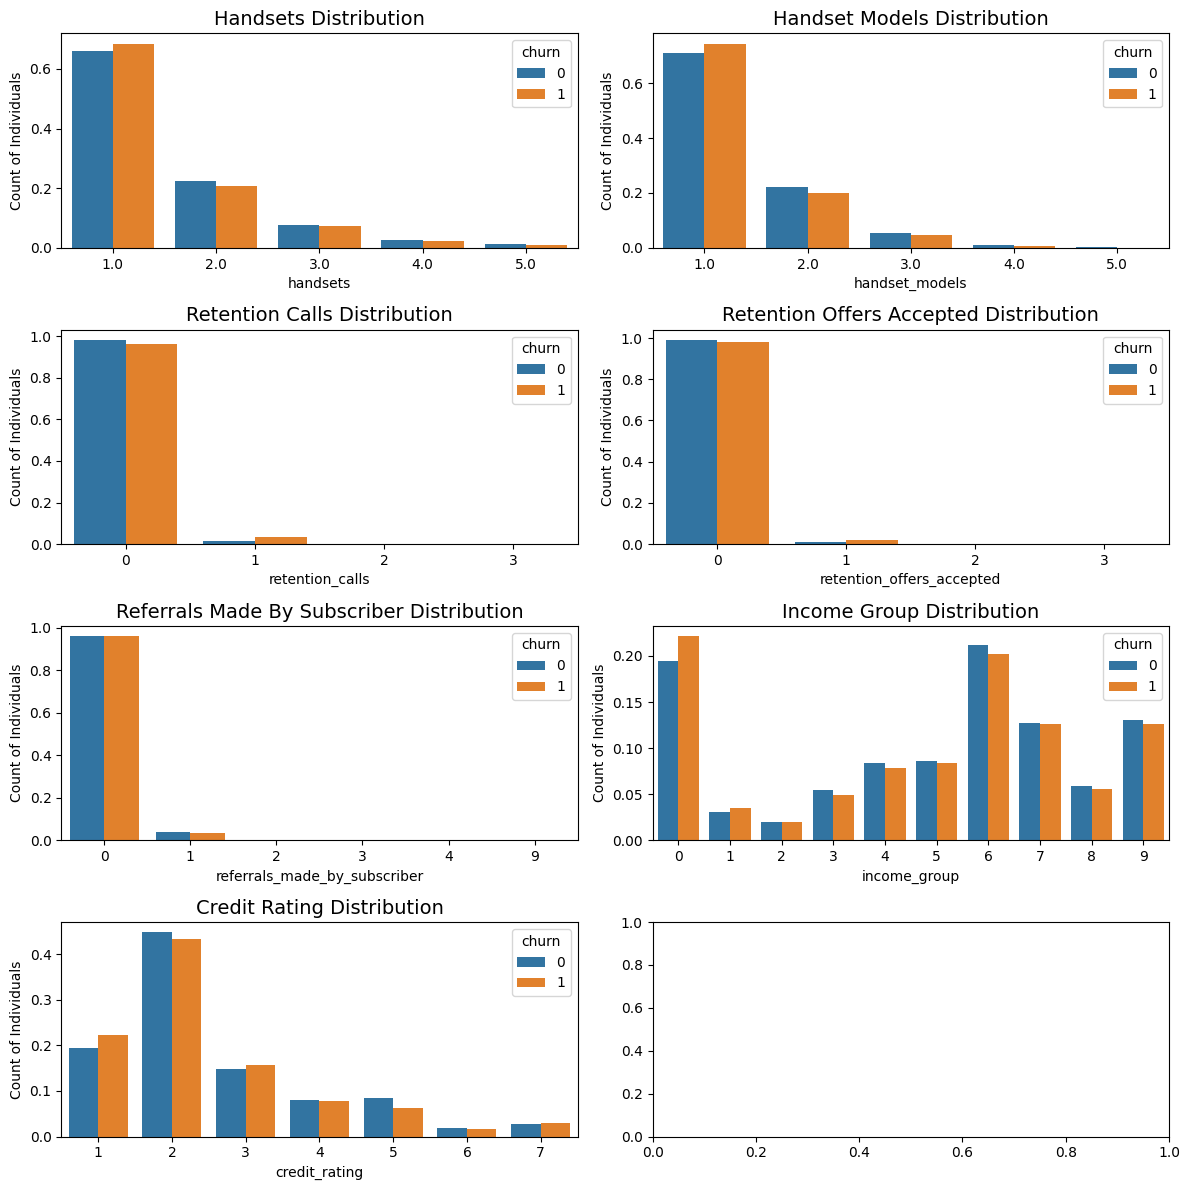

In [73]:
train = pd.concat([X_train, y_train], axis=1)

fig, ax = plt.subplots(4, 2, figsize=(12, 12))

for ax, column in zip(ax.ravel(), discrete_vars[1:]):  # Drop ID
    counts = (
        train[[column, "churn"]]
        .groupby("churn")
        .value_counts(normalize=True)
        .reset_index()
    )
    counts = counts.sort_values(column)

    sns.barplot(x=column, y="proportion", data=counts, ax=ax, hue="churn")
    ax.set_title(f"{split_snake_case(column)} Distribution", fontsize=14)
    ax.set_ylabel("Count of Individuals")
    ax.set_xlabel(column)
    if counts[column].nunique() > 10:
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks[::2])

plt.tight_layout()

In [74]:
if output_img:
    fig.savefig('./img/m3_fig1.png', format='png', dpi=300, bbox_inches='tight')

#### Continuous Variables

In [75]:
continuous_vars

['perc_change_minutes',
 'perc_change_revenues',
 'dropped_calls',
 'unanswered_calls',
 'received_calls',
 'months_in_service',
 'unique_subs',
 'current_equipment_days',
 'age_hh1',
 'age_hh2',
 'adjustments_to_credit_rating',
 'handset_price',
 'total_care_issues',
 'overall_revenue',
 'overall_usage',
 'value_added_service_usage',
 'total_calls',
 'total_peak_off_peak_calls']

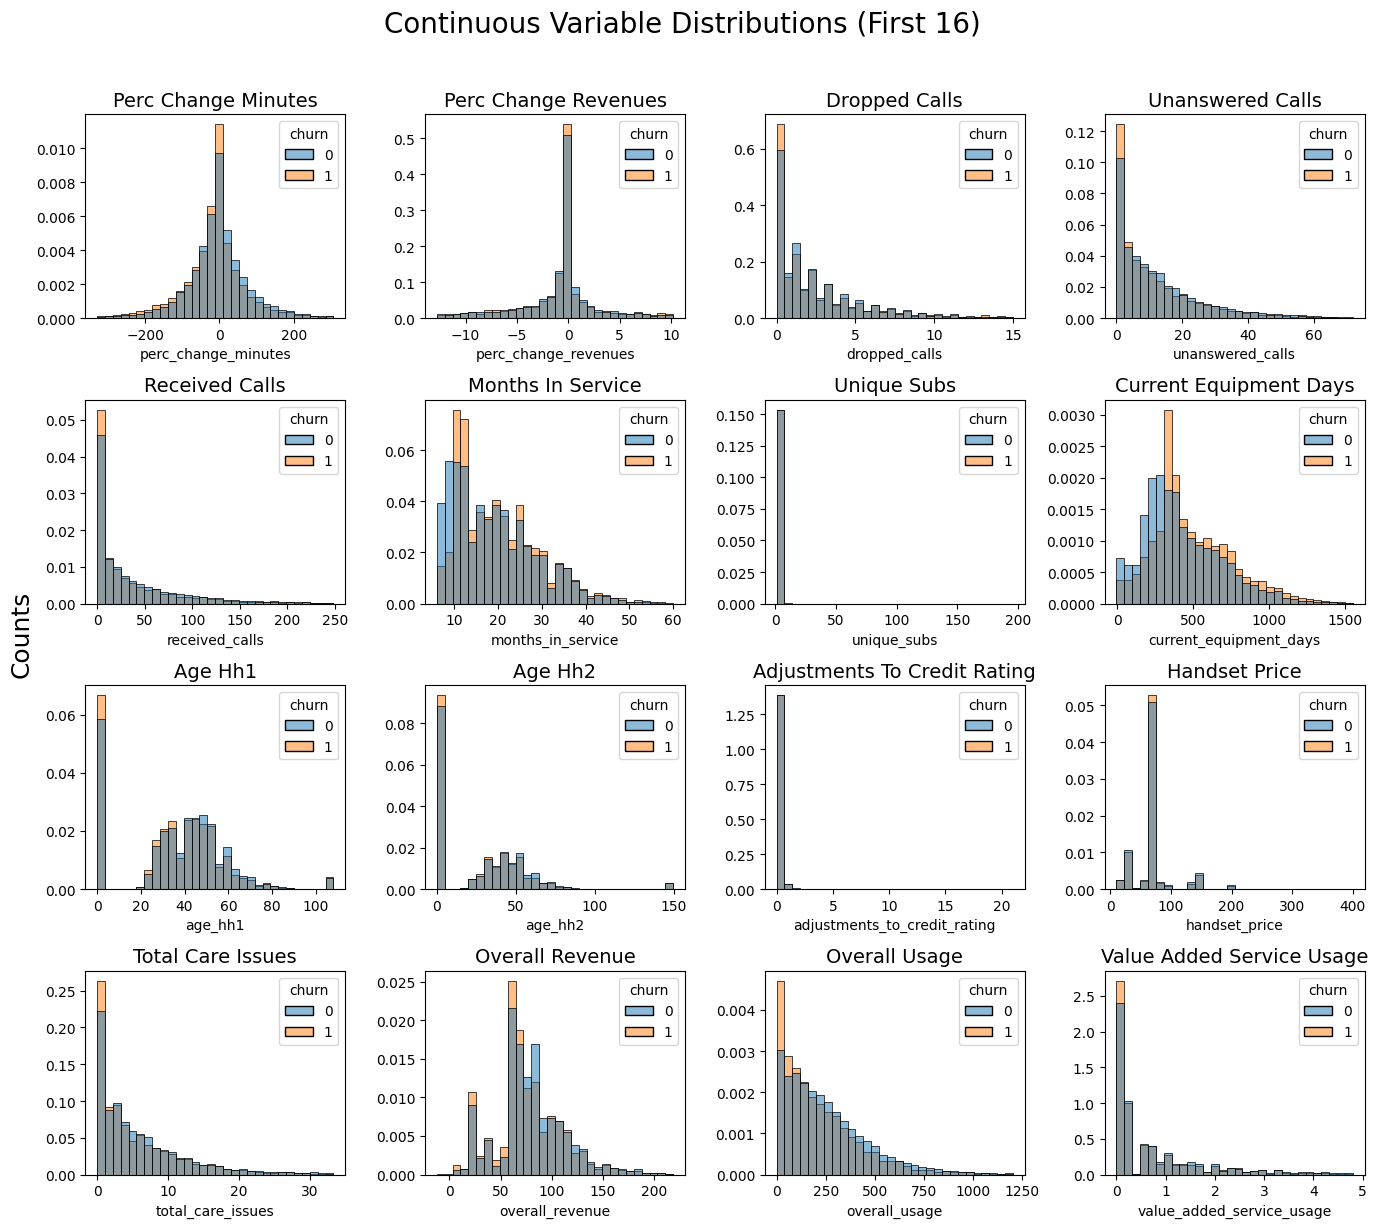

In [76]:
fig, ax = plt.subplots(4, 4, figsize=(14, 12))

for ax, column in zip(ax.ravel(), continuous_vars[:16]):
    sns.histplot(
        x=column,
        data=train[[column, "churn"]],
        bins=30,
        ax=ax,
        hue="churn",
        stat="density",
        common_norm=False,
    )
    ax.set_title(f"{split_snake_case(column)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(column)
fig.supylabel("Counts", fontsize=18)
fig.suptitle("Continuous Variable Distributions (First 16)", fontsize=20, y=1.02)
plt.tight_layout()

In [77]:
if output_img:
    fig.savefig('./img/m3_fig3a.png', format='png', dpi=300, bbox_inches='tight')

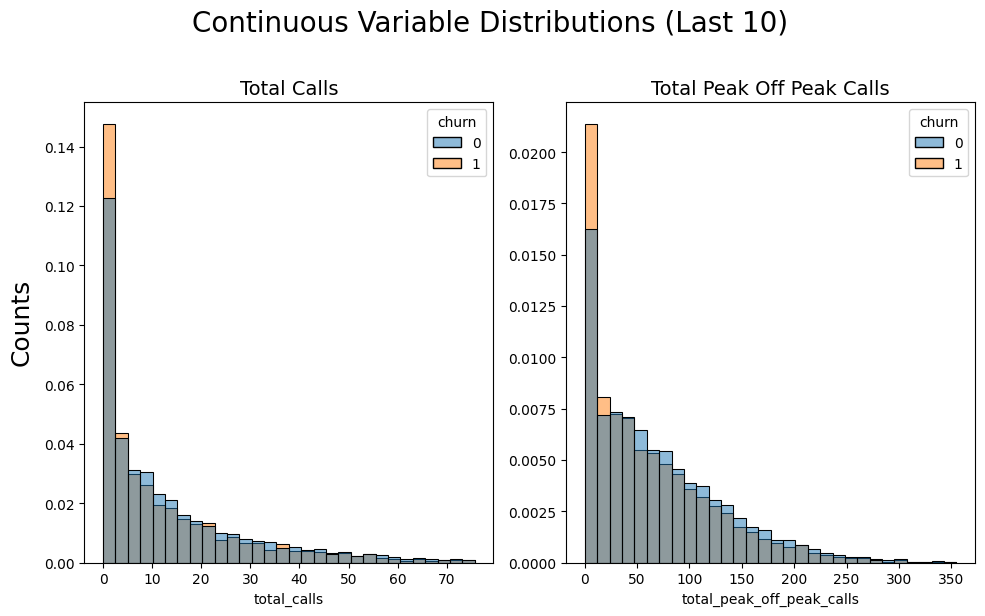

In [78]:
# Sorry for the redundant code
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

axes = ax.ravel()
for ax, column in zip(axes, continuous_vars[16:]):
    sns.histplot(
        x=column, 
        data=train[[column, "churn"]], 
        bins=30, 
        ax=ax, 
        hue="churn", 
        stat="density", 
        common_norm=False
    )
    ax.set_title(f'{split_snake_case(column)}', fontsize=14)
    ax.set_ylabel('')
    ax.set_xlabel(column)
fig.supylabel('Counts', fontsize=18)
fig.suptitle('Continuous Variable Distributions (Last 10)', fontsize=20, y=1.02)
# axes[-1].set_visible(False)
# axes[-2].set_visible(False)
plt.tight_layout()

In [79]:
if output_img:
    fig.savefig('./img/m3_fig3b.png', format='png', dpi=300, bbox_inches='tight')

##### Box Plots

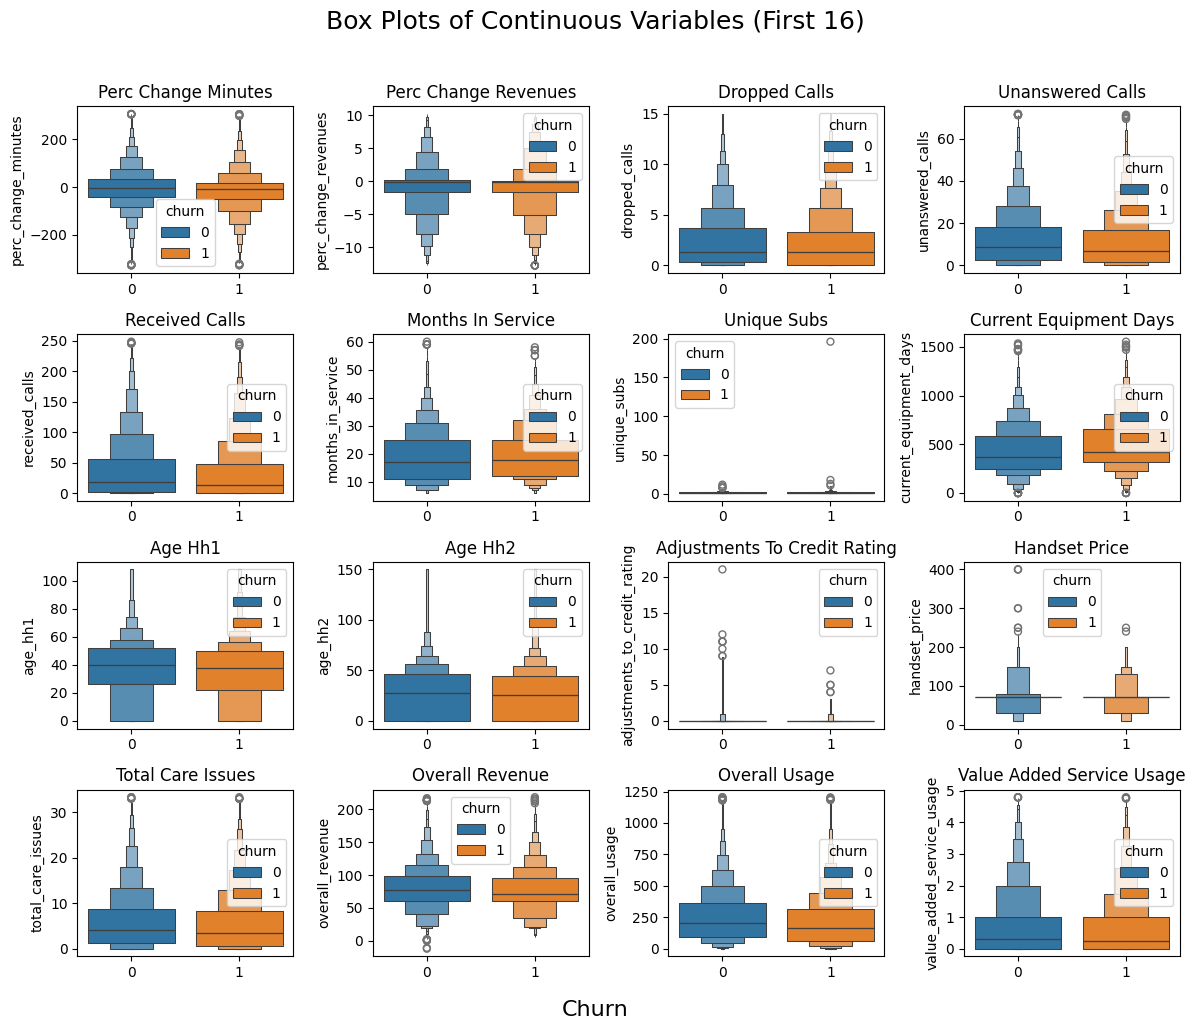

In [80]:
fig, ax = plt.subplots(4, 4, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(), continuous_vars[:16]):

    _=sns.boxenplot(
        x="churn", 
        y=feature, 
        data=train,
        hue='churn', 
        ax=ax
    )
    ax.set_title(split_snake_case(feature).title())
    ax.set_xlabel("")

plt.suptitle("Box Plots of Continuous Variables (First 16)", fontsize = 18, y=1.02)
fig.supxlabel("Churn", fontsize=16)
plt.tight_layout()

In [81]:
if output_img:
    fig.savefig('./img/m3_fig3c.png', format='png', dpi=300, bbox_inches='tight')

#### Binary Variables

In [82]:
# Remove zero-inflated dummies
binary_vars_to_plot = [var for var in binary_vars if var.split("_")[-1] != 'zero']
binary_vars_to_plot

['children_in_hh',
 'handset_refurbished',
 'handset_web_capable',
 'truck_owner',
 'rv_owner',
 'homeownership',
 'buys_via_mail_order',
 'responds_to_mail_offers',
 'opt_out_mailings',
 'non_us_travel',
 'owns_computer',
 'has_credit_card',
 'new_cellphone_user',
 'owns_motorcycle',
 'made_call_to_retention_team',
 'prizm_code_Rural',
 'prizm_code_Suburban',
 'prizm_code_Town',
 'occupation_Crafts',
 'occupation_Homemaker',
 'occupation_Other',
 'occupation_Professional',
 'occupation_Retired',
 'occupation_Self',
 'occupation_Student',
 'marital_status_Unknown',
 'marital_status_Yes']

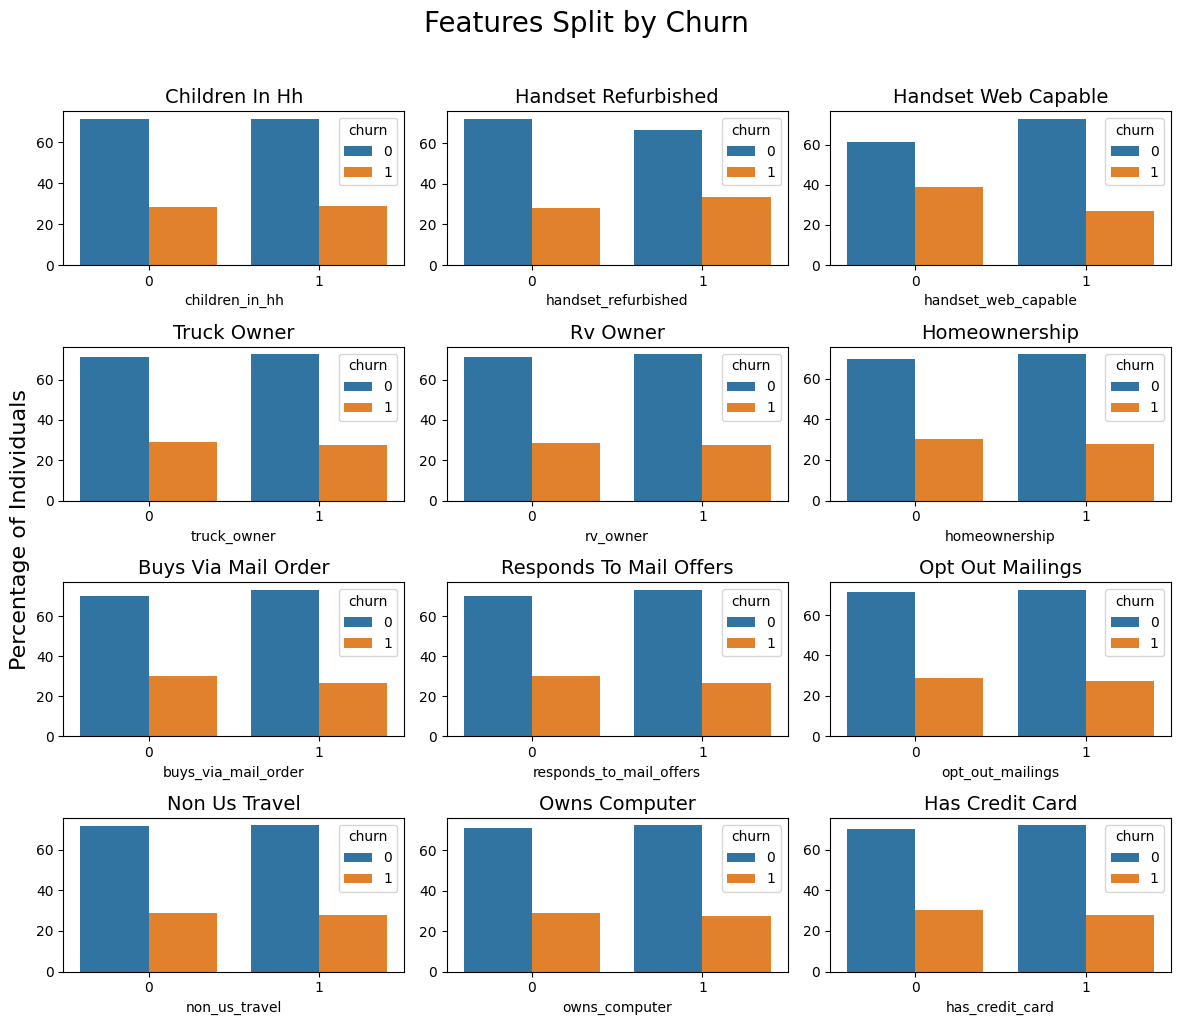

In [83]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[:12]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

In [84]:
if output_img:
    fig.savefig('./img/m3_fig4.png', format='png', dpi=300, bbox_inches='tight')

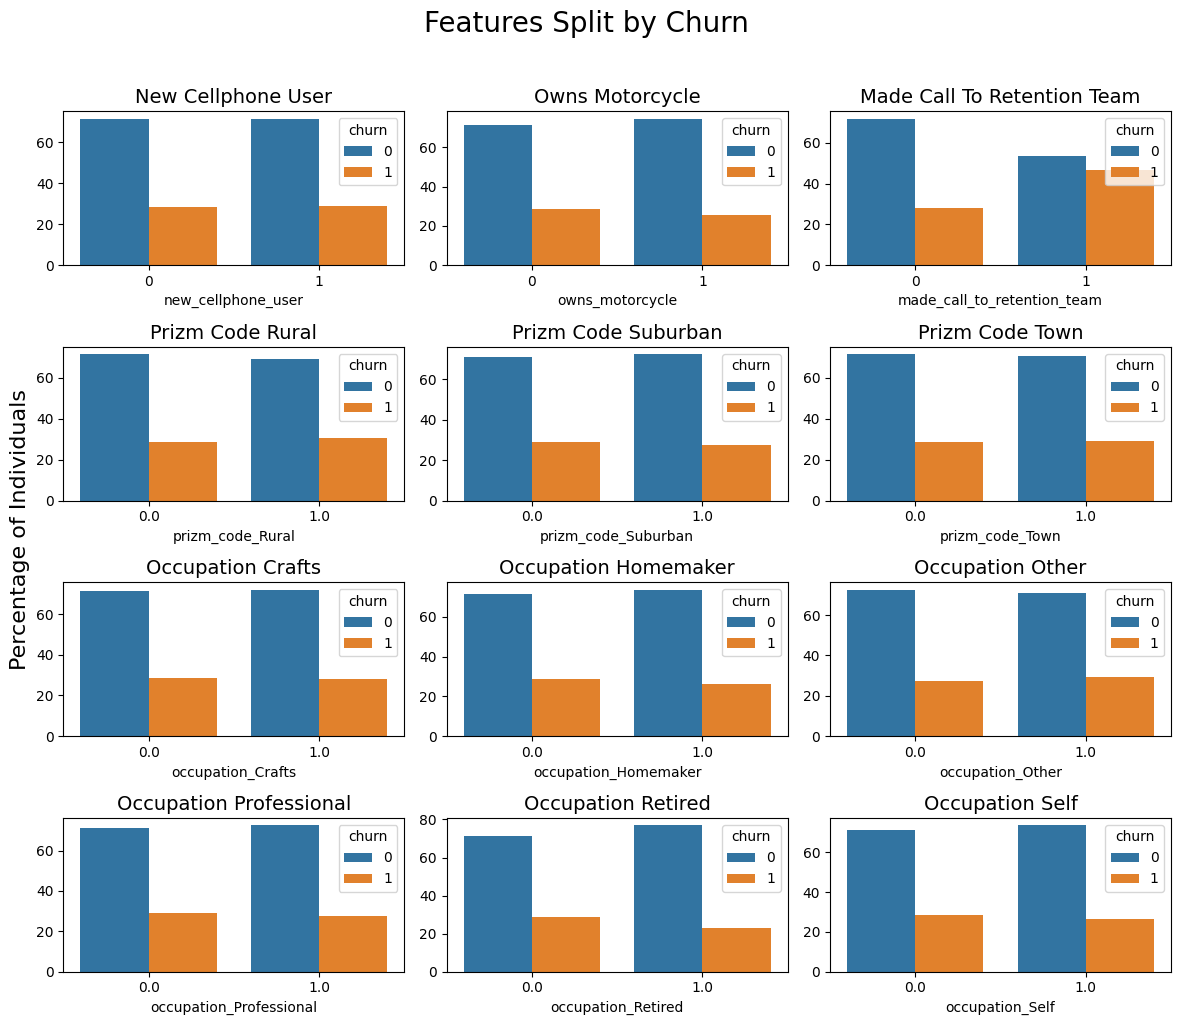

In [85]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[12:]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

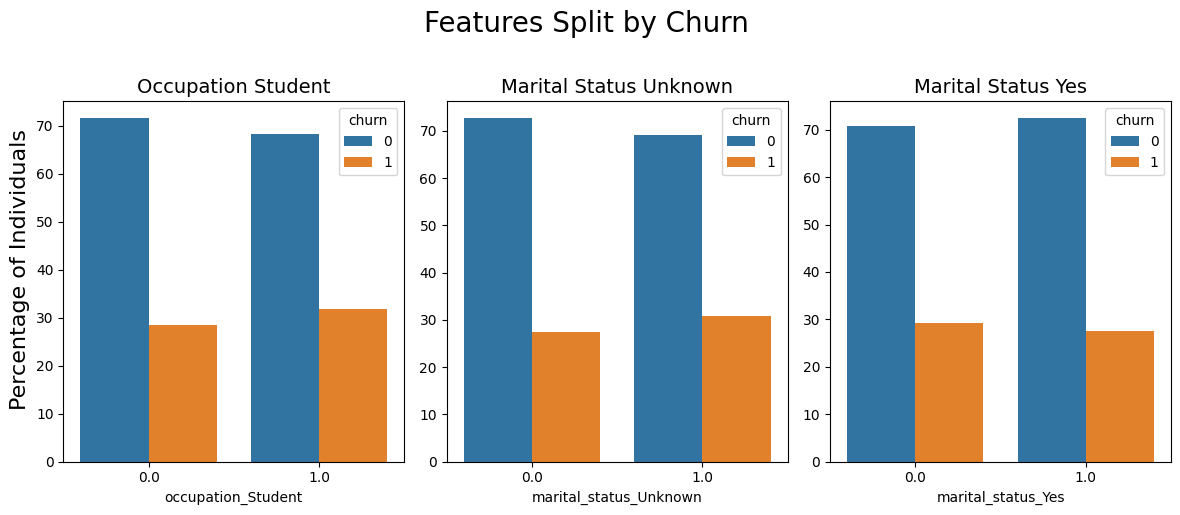

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[24:]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

## Exploratory Data Analysis

### Deeper Understanding of the Data

*While basic EDA is important, you should aim to provide a deeper understanding of the data through your analysis. This can be achieved by identifying patterns, trends, class imbalances, and outliers in the data. Additionally, explore the relationships between variables and identify any potential confounding variables that may impact the analysis.*

1. Trends: We explored the trend using the only temporal feature "MonthsInService"
   - Initial drop: The churn rate starts around 0.2, drops slightly.
   - Sharp increase: The churn rate increases sharply around the 10 month mark. This could indicate that the users may have some sort of contract that binds them for 10 months.
   - Stablizes: After the spike on the 10th month, churn rate slightly declines and stabilize hovering over 0.2 ~ 0.4 over the next several months.
   - Large fluctuation >50 months: Twards the end, the data shows heavy fluctuation and a spike at the end indicating a potential outlier.
3. Class imbalance: Class imbalance was previously identified and handeled in MS2
4. Outliers:
   - We can identify from the box plot and distribution plots that there are outliers in the dataset. Instead of removing the outliers right now, we'll use different methods such as (1) Cook's distance (if using linear regression) and (2) principal component analysis (PCA) to handle outliers. 
5. Relationship between variables:
   We found strong correlations between features that can lead to multicollinearity. (both shown in the heatmap and pairplots) Later we'll explore methods such as (1) removing one of the correlated features, (2) PCA, (3) feature selection to determine the best method to handle multicollinearity issue.
   - MonthlyRevenue & OverageMinutes: 0.786
   - MonthlyRevenue & MonthlyMinutes: 0.710
   - MonthlyMinutes & ReceivedCalls: 0.828


   However, we didn't find any feature that has direct correlation with Churn. This is interesting as we were expecting at least a weak correlation between some features and churn. It suggests that chrun might depend on more complex interactions between multiple features. 

#### Trends

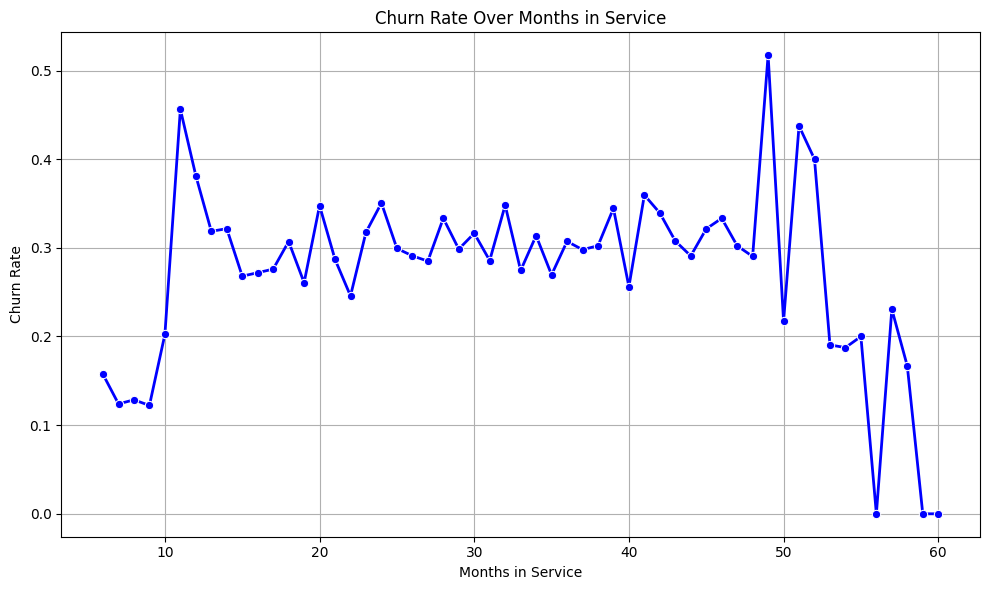

In [87]:
# Identifying the trend using time trended variable: "MonthsInSerivce"

monthly_churn_rate = train.groupby('months_in_service')['churn'].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.lineplot(x='months_in_service', y='churn', data=monthly_churn_rate, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

plt.title('Churn Rate Over Months in Service')
plt.xlabel('Months in Service')
plt.ylabel('Churn Rate')
plt.grid(True)
plt.tight_layout();

if output_img:
    plt.savefig('./img/m3_fig5.png', format='png', dpi=300, bbox_inches='tight')



#### Correlation Matrices

In [88]:
batches = list(zip(list(range(0, len(continuous_vars)+1, 6)), list(range(0, len(continuous_vars)+1, 6))[1:]))

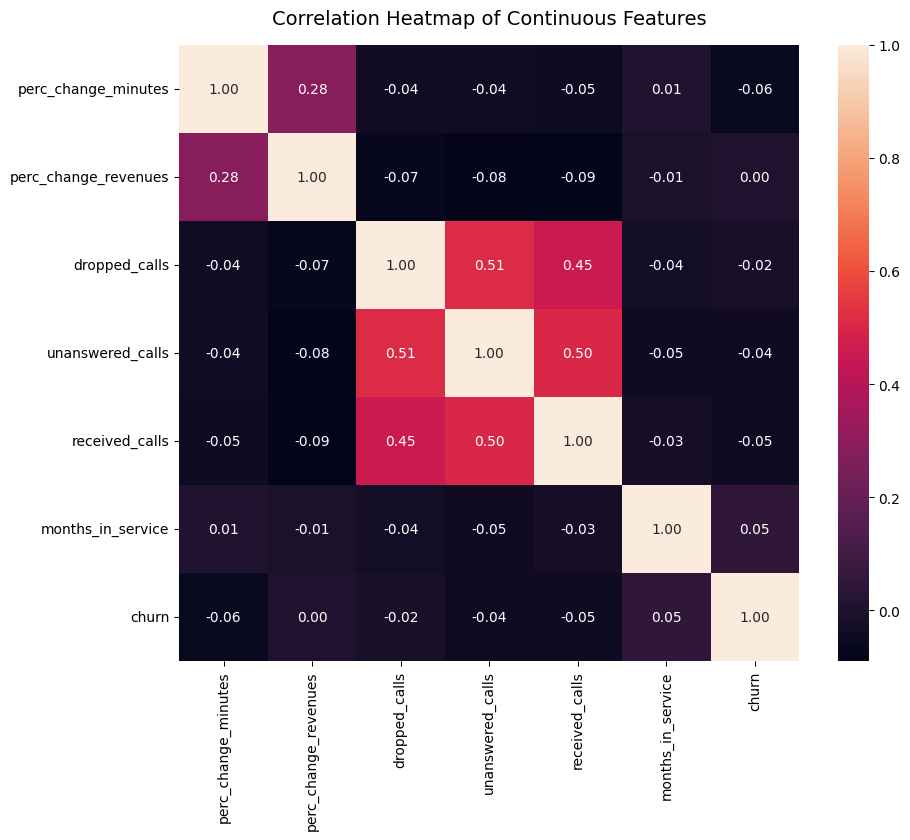

Strong correlations:
                       perc_change_minutes  perc_change_revenues  \
perc_change_minutes                   1.0                   NaN   
perc_change_revenues                  NaN                   1.0   
dropped_calls                         NaN                   NaN   
unanswered_calls                      NaN                   NaN   
received_calls                        NaN                   NaN   
months_in_service                     NaN                   NaN   
churn                                 NaN                   NaN   

                      dropped_calls  unanswered_calls  received_calls  \
perc_change_minutes             NaN               NaN             NaN   
perc_change_revenues            NaN               NaN             NaN   
dropped_calls                   1.0               NaN             NaN   
unanswered_calls                NaN               1.0             NaN   
received_calls                  NaN               NaN             1.0   
mon

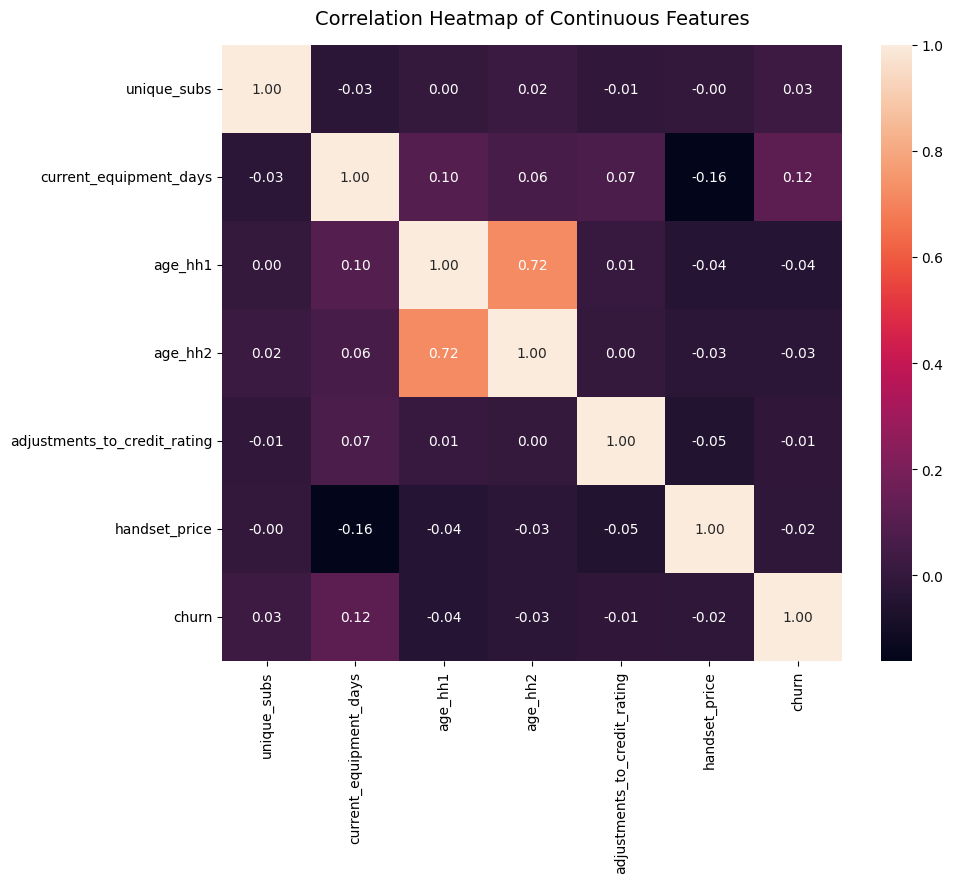

Strong correlations:
                               unique_subs  current_equipment_days   age_hh1  \
unique_subs                           1.0                     NaN       NaN   
current_equipment_days                NaN                     1.0       NaN   
age_hh1                               NaN                     NaN  1.000000   
age_hh2                               NaN                     NaN  0.722293   
adjustments_to_credit_rating          NaN                     NaN       NaN   
handset_price                         NaN                     NaN       NaN   
churn                                 NaN                     NaN       NaN   

                               age_hh2  adjustments_to_credit_rating  \
unique_subs                        NaN                           NaN   
current_equipment_days             NaN                           NaN   
age_hh1                       0.722293                           NaN   
age_hh2                       1.000000                   

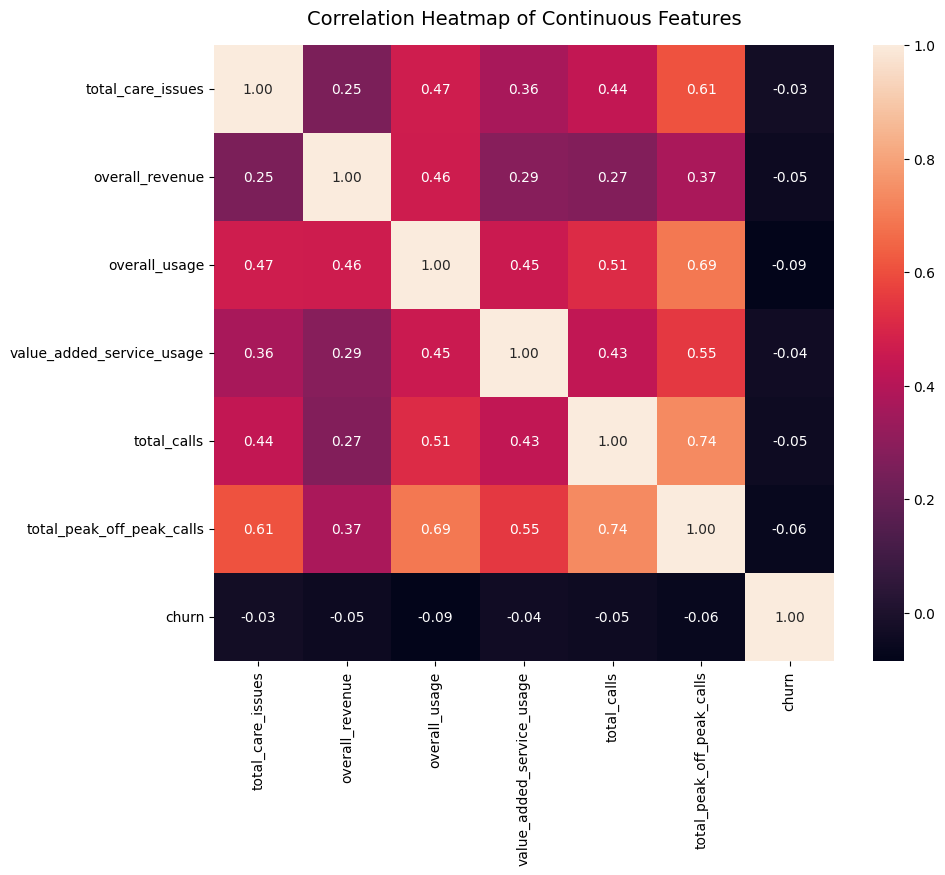

Strong correlations:
                            total_care_issues  overall_revenue  overall_usage  \
total_care_issues                   1.000000              NaN            NaN   
overall_revenue                          NaN              1.0            NaN   
overall_usage                            NaN              NaN        1.00000   
value_added_service_usage                NaN              NaN            NaN   
total_calls                              NaN              NaN            NaN   
total_peak_off_peak_calls           0.608967              NaN        0.69385   
churn                                    NaN              NaN            NaN   

                           value_added_service_usage  total_calls  \
total_care_issues                                NaN          NaN   
overall_revenue                                  NaN          NaN   
overall_usage                                    NaN          NaN   
value_added_service_usage                        1.0         

In [89]:
# Correlation heatmap for continuous variables

for letter, batch in zip(string.ascii_lowercase, batches):
    correlation_matrix = pd.concat([train[continuous_vars[batch[0]:batch[1]]], train['churn']], axis=1).corr(method='pearson')
    fig, ax = plt.subplots(figsize=(10, 8))  
    sns.heatmap(
        correlation_matrix, 
        annot=True,
        fmt=".2f",
        ax=ax
    )
    ax.set_title('Correlation Heatmap of Continuous Features', fontsize=14, y=1.02)
    plt.show();

    # Identify strong correlations (greater than 0.6 or less than -0.6)
    strong_corr = correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)]
    print("Strong correlations:\n", strong_corr)

    if output_img:
        fig.savefig(f'./img/m3_fig6{letter}.png', format='png', dpi=300, bbox_inches='tight')

In [90]:
# Calculate correlations with response
correlations = train[continuous_vars].corrwith(train["churn"])

# Sort correlations in descending order (absolute values for strength)
sorted_correlations = correlations.abs().sort_values(ascending=False)
top5_features = list(sorted_correlations.head(5).index) + ["churn"]
top5_features

['current_equipment_days',
 'overall_usage',
 'perc_change_minutes',
 'total_peak_off_peak_calls',
 'overall_revenue',
 'churn']

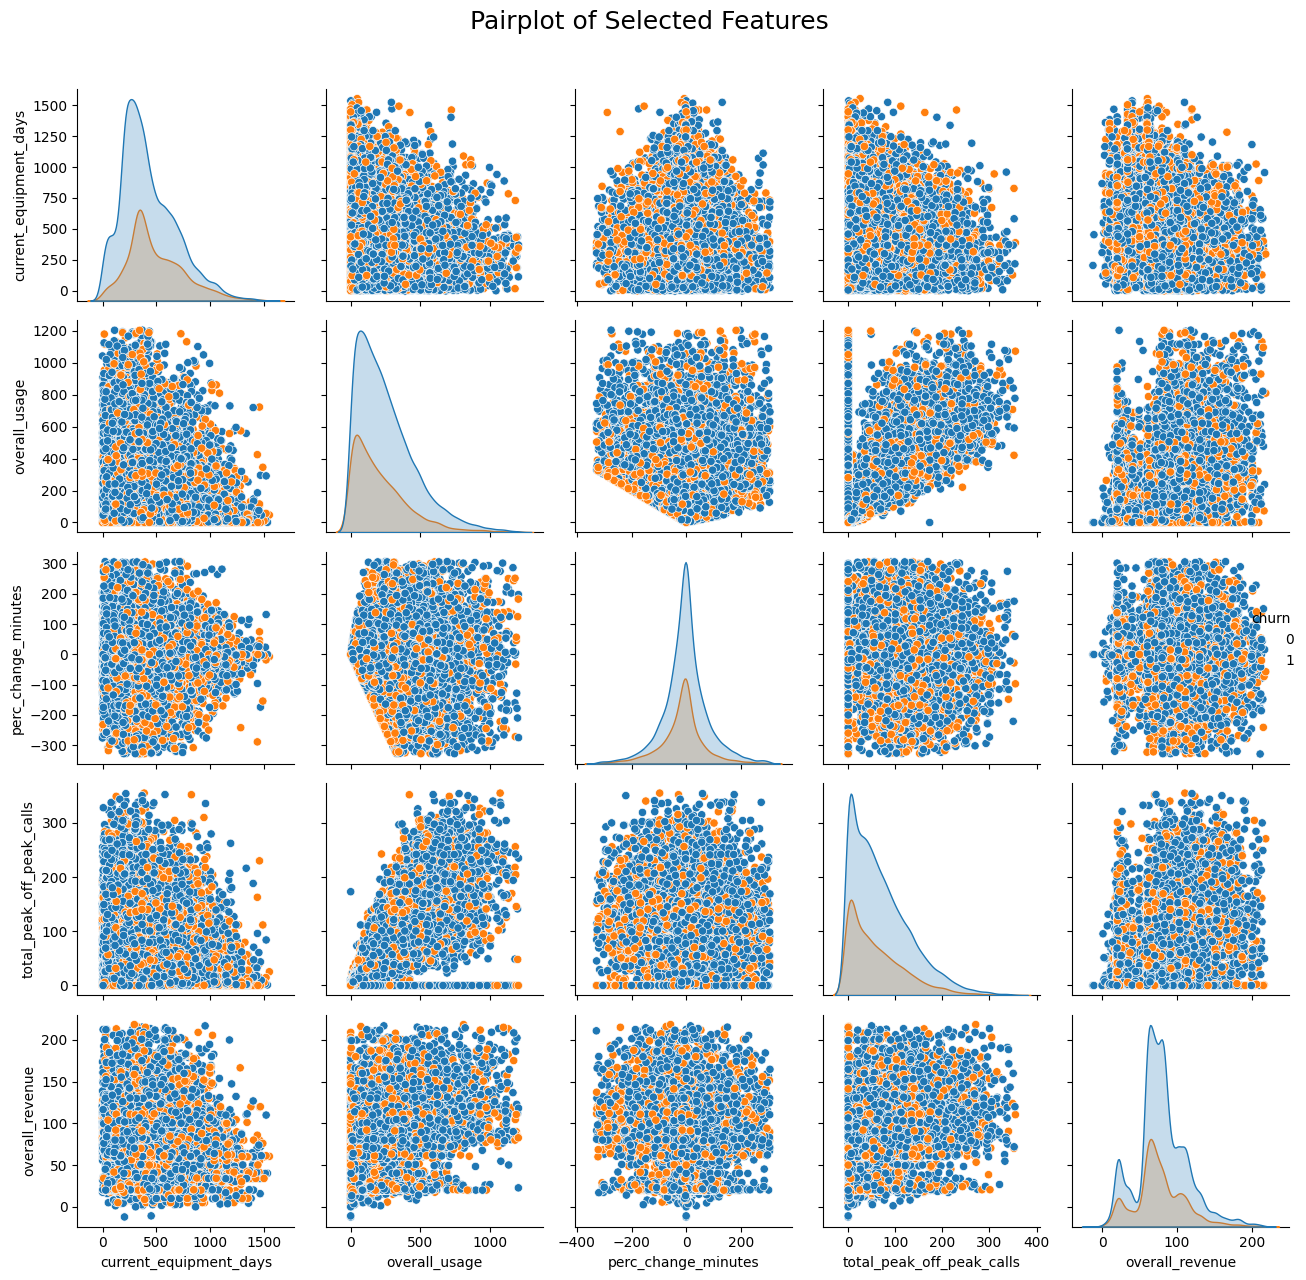

In [91]:
# Pairplot of selected features (can delete them if it is confusing)
pairplot = sns.pairplot(
    train[top5_features], 
    hue='churn'
)
plt.suptitle('Pairplot of Selected Features', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [92]:
if output_img:
    pairplot.savefig(f'./img/m3_fig7.png', format='png', dpi=300, bbox_inches='tight')

### Meaningful Insights

The EDA report should provide meaningful insights that can be connected back to the problem at hand. These insights should be well-supported by the data and provide actionable recommendations for addressing the problem. You should focus on providing insights that are relevant to the project question and will add value to the final analysis.

### Noteworthy Findings

Summarize the noteworthy findings of their EDA in a clear and concise manner. This can be achieved through the use of visualizations and captions that highlight the most important insights gained through the analysis.

#### Service Quality Impact
- Based on the correlation heatmap and pair plot, we don’t see a strong direct correlation between `DroppedCalls` and `Churn`. This suggests that while service quality could impact churn, `DroppedCalls` alone does not show a significant linear relationship with churn.

#### Financial Patterns
- **Revenue & Charges**: The correlation heatmap shows a strong relationship between `MonthlyRevenue` and `OverageMinutes` (0.79), as well as `MonthlyRevenue` and `MonthlyMinutes` (0.71). 
- **Churn Correlation**: There is a very weak or negligible correlation between financial variables like `MonthlyRevenue`, `TotalRecurringCharge`, and churn, suggesting that churn is likely influenced by more complex interactions of these variables rather than a single factor.

#### Demographic Insights
- **Credit Rating**: Credit rating distribution shows a higher density of churn among customers with a medium (2-High) credit rating.
- **Income Group**: Income Group 6 has the highest representation, while Income Group 0 shows a more varied churn rate.

#### Continuous Variables Analysis
- **Monthly Revenue**: The distribution is heavily right-skewed, with most customers having a monthly revenue below.
- **Monthly Minutes**: Similarly right-skewed, showing that most customers have low usage, but a few consume a large number of minutes.
- **Total Recurring Charge**: Right-skewed distribution suggests that most customers have low recurring charges.

#### Churn Trends Over Time
- **10-Month Spike**: The churn rate chart shows a significant increase around the 10-month mark, possibly indicating a contract or milestone prompting churn.
- **Long-Term Fluctuations**: After stabilizing around 20-40% for most of the service period, churn rate experiences fluctuations after 50 months, with a sharp peak at the end. 

#### Correlation Insights
- **Feature Correlations**: The heatmap shows strong correlations between features like `MonthlyRevenue` & `OverageMinutes` (0.79) and `MonthlyMinutes` & `ReceivedCalls` (0.83), indicating potential multicollinearity, which might need addressing in modeling.
- **No Strong Correlation with Churn**: None of the variables exhibit a strong correlation with churn.


## Research Question

Based on the insights gained through EDA, you should develop a clear project question that will guide your analysis. This question should be well-defined and specific to the problem at hand.

1. **"What variables influence churn, and how can these factors be effectively used to predict customer churn?"**

2. **"How do service usage patterns and financial characteristics, such as monthly revenue and overage charges, impact customer churn rates?"**

3. **"What role do demographic factors (such as income, location, and credit rating) play in predicting customer churn?"**



## Baseline Models

This section focuses on the development and evaluation of two baseline models 1) A naive model that predicts random labels based on the class distribution and 2) a bare bones logistic regression model. These two models serve as the baseline metric to beat going forward. A variety of metrics were employed to comprehensively assess the differences in their predictive performance, such as f1-score and accuracy.

### Naive Model

In [93]:
naive_model = DummyClassifier(strategy="stratified")
naive_model.fit(X_train, y_train)
y_pred_naive = naive_model.predict(X_train)

print ("Naive Model - Train Data")
print ("="*53)
print (classification_report(y_train, y_pred_naive))

Naive Model - Train Data
              precision    recall  f1-score   support

           0       0.72      0.72      0.72     14663
           1       0.29      0.29      0.29      5857

    accuracy                           0.60     20520
   macro avg       0.51      0.51      0.51     20520
weighted avg       0.60      0.60      0.60     20520



In [94]:
naive_model = DummyClassifier(strategy="stratified")
naive_model.fit(X_test, y_test)
y_pred_naive = naive_model.predict(X_test)

print ("Naive Model - Test Data")
print ("="*53)
print (classification_report(y_test, y_pred_naive))

Naive Model - Test Data
              precision    recall  f1-score   support

           0       0.72      0.71      0.72      3678
           1       0.28      0.29      0.28      1453

    accuracy                           0.59      5131
   macro avg       0.50      0.50      0.50      5131
weighted avg       0.59      0.59      0.59      5131



### Logistic Regression

The baseline model was designed as a straightforward Logistic Regression model with the following specifications:
- No regularisation (penalty=None).
- Class weights were set to balanced (class_weight="balanced") to address class imbalance.
- The model was trained on a subset of features (top5_features), selected based on their importance.

In [95]:
if "churn" in top5_features:
    top5_features.remove("churn")

In [96]:
logit_model = LogisticRegression(
    penalty=None, random_state=random_state, class_weight="balanced"
)
logit_model.fit(X_train[top5_features], y_train.values.ravel())

y_pred_logit = logit_model.predict(X_train[top5_features])

print("Logit Model - Train Data")
print ("="*53)
print(classification_report(y_train, y_pred_logit))

Logit Model - Train Data
              precision    recall  f1-score   support

           0       0.78      0.57      0.66     14663
           1       0.36      0.59      0.44      5857

    accuracy                           0.58     20520
   macro avg       0.57      0.58      0.55     20520
weighted avg       0.66      0.58      0.60     20520



In [97]:
logit_model = LogisticRegression(
    penalty=None, random_state=random_state, class_weight="balanced"
)
logit_model.fit(X_test[top5_features], y_test.values.ravel())

y_pred_logit = logit_model.predict(X_test[top5_features])

print("Logit Model - Test Data")
print ("="*53)
print(classification_report(y_test, y_pred_logit))

Logit Model - Test Data
              precision    recall  f1-score   support

           0       0.77      0.55      0.65      3678
           1       0.34      0.59      0.43      1453

    accuracy                           0.56      5131
   macro avg       0.56      0.57      0.54      5131
weighted avg       0.65      0.56      0.59      5131



The performance of the baseline logistic regression reveals challenges due to class imbalance, with class 0 (14,663 samples) dominating class 1 (5,857 samples). The model achieves a modest overall accuracy of 0.58, performing better on class 0 (precision: 0.78, recall: 0.57) compared to class 1 (precision: 0.36, recall: 0.59). 

The low f1-score of 0.44 for class 1 highlights difficulties in effectively distinguishing the minority class, likely caused by overlapping feature distributions or inadequate class representation.

The macro average metrics (precision: 0.57, recall: 0.58, F1-score: 0.55) indicate moderate performance across both classes, while the weighted averages slightly favour class 0. To improve, techniques like oversampling (e.g., SMOTE), feature engineering, or hyperparameter tuning should be employed. 

## Models

### Tuned Logistic Regression
Learning form the baseline model, the improved model employs advanced techniques to enhance performance:
- L1 Regularisation (penalty="l1") was applied to facilitate feature selection.
- The $C = \frac{1}{\lambda}$ hyperparameter was optimised using cross-validation with LogisticRegressionCV.
- The training dataset was pre-processed to ensure balanced class distributions, improving model robustness.
- The solver `liblinear` was selected because it had no convergence issues.
- PCA was used on binary variables to reduce dimensionality and improve model performance. 90% of the variance was retained.

For the model pipeline, the following steps were implemented:
1. Scaling: we scale before SMOTE to prevent data leakage because if we scale after SMOTE, we're giving information to the scaler about the data generation process of SMOTE. Another way to put it, the mean and standard deviation that is computed from the SMOTE data provides information about how SMOTE was generated and therefore, the model will be able to pick up on that.
2. SMOTE: we oversample the minority class to balance the class distribution.
3. Logistic Regression: we fit the model using the optimised hyperparameters.
4. We use a pipeline to ensure that the SMOTE operates only on the training data and is not applied to the test data

Source:
https://stackoverflow.com/questions/77446462/the-right-way-of-using-smote-in-classification-problems

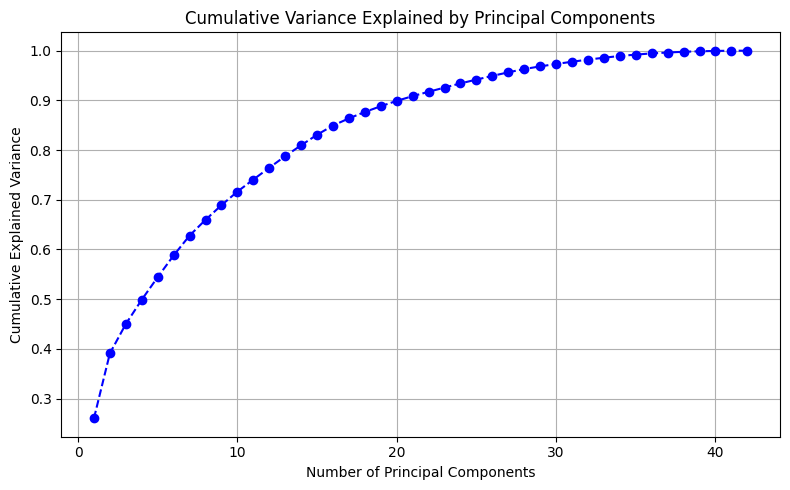

21 components explain 90.0% of the variance.


In [98]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca.fit(X_train[binary_vars])

# Plot the cumulative explained variance, scree plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select components that explain 90% of the variance
cutoff = 0.90
best_n_components = np.argmax(cumulative_variance > cutoff) + 1
print (f"{best_n_components} components explain {cutoff*100}% of the variance.")


In [99]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars),
        ('pca', PCA(n_components=best_n_components), binary_vars)
    ], 
    remainder='passthrough', #binary variables passthrough
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', numeric_transformer),
        ("smote", SMOTE(sampling_strategy="auto", random_state=random_state)),
        (
            "clf",
            LogisticRegressionCV(
                Cs=np.logspace(-6, 6, 13),
                cv=5,
                penalty="l1",
                solver="liblinear",
                random_state=random_state,
                max_iter=2000,
                n_jobs=-1,
                class_weight="balanced",
                scoring="accuracy",
            ),
        ),
    ]
)


pipeline.fit(X_train, y_train.values.ravel())

print(
    "Train Accuracy: {:.4f}".format(pipeline.score(X_train, y_train)),
)


Train Accuracy: 0.6011


In [100]:
# Get out the components of the pipelines
X_train_scaled = pipeline.named_steps["preprocessor"].transform(X_train)
X_train_smote, y_train_smote = pipeline.named_steps["smote"].fit_resample(X_train_scaled, y_train)

X_test_scaled = pipeline.named_steps["preprocessor"].transform(X_test)
X_test_smote, _ = pipeline.named_steps["smote"].fit_resample(X_test_scaled, y_test)

best_logit_model = pipeline.named_steps["clf"]


#### Classification Report 

##### Train Set

In [101]:
# classification report using train data
y_train_pred_logit = pipeline.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_logit , zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68     14663
           1       0.37      0.60      0.46      5857

    accuracy                           0.60     20520
   macro avg       0.58      0.60      0.57     20520
weighted avg       0.67      0.60      0.62     20520



##### Test Set

In [102]:
# classification report using test data
y_test_pred_logit = pipeline.predict(X_test)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_logit, zero_division=0))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.77      0.59      0.67      3678
           1       0.35      0.56      0.43      1453

    accuracy                           0.58      5131
   macro avg       0.56      0.58      0.55      5131
weighted avg       0.65      0.58      0.60      5131



The model performs consistently across training (accuracy: 0.60) and test datasets (accuracy: 0.58), demonstrating the model is not overfitting since the two values are close. Comparing the tuned logit to the baseline logit we see a slight improvement across the train and test sets for all metrics.

**Model Performance:**

| Metric         | Baseline Logit | Tuned Logit |
|----------------|----------------|-------------|
| Train Accuracy | 0.58           | 0.60        |
| Test Accuracy  | 0.56           | 0.58        |
| Train F1 Score | 0.55           | 0.57        |
| Test F1 Score  | 0.54           | 0.55        |

#### Confusion Matrix

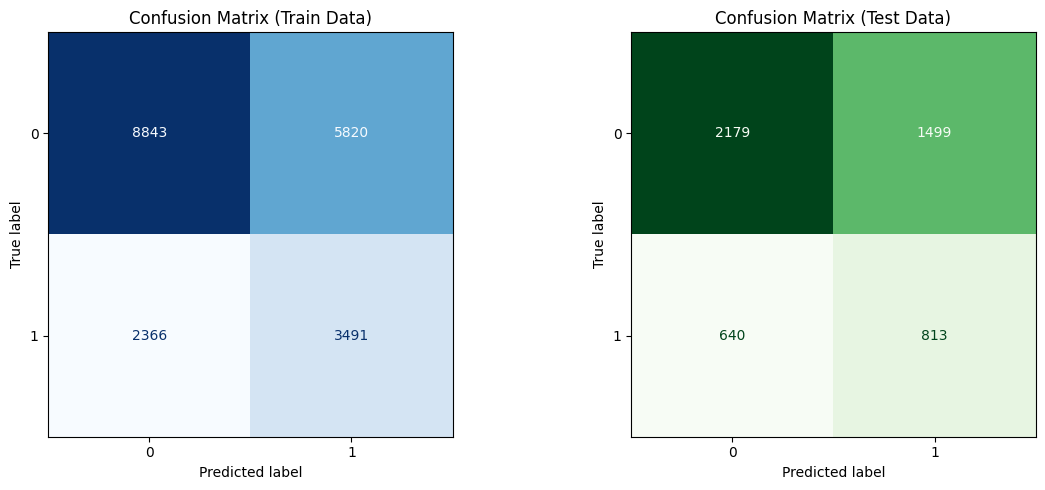

In [103]:
# CM Train data
cm_train = confusion_matrix(y_train, y_train_pred_logit)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=pipeline.classes_)

#  CM Test Data
cm_test = confusion_matrix(y_test, y_test_pred_logit)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=pipeline.classes_)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_train.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix (Train Data)')

disp_test.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('Confusion Matrix (Test Data)')
plt.tight_layout()

The confusion matrices reveal consistent performance across training and test datasets. 

Overall the model does pretty poorly, especially with regards to false positives. True negatives look decent but ideally we would want more values in the diagonals. The number of false negatives is decent but just barely. 

#### Feature Importance 

In [104]:
# extract features that have coefficient > shreshold
coefficients = best_logit_model.coef_.flatten()
threshold = 0.2
selected_features = [
    feature
    for feature, coef in zip(X_train.columns, coefficients)
    if abs(coef) > threshold
]
selected_coefficients = [coef for coef in coefficients if abs(coef) > threshold]

top_coefficients = pd.DataFrame(
    {"feature": selected_features, "coefficient": selected_coefficients}
).sort_values("coefficient", ascending=True, key=abs)

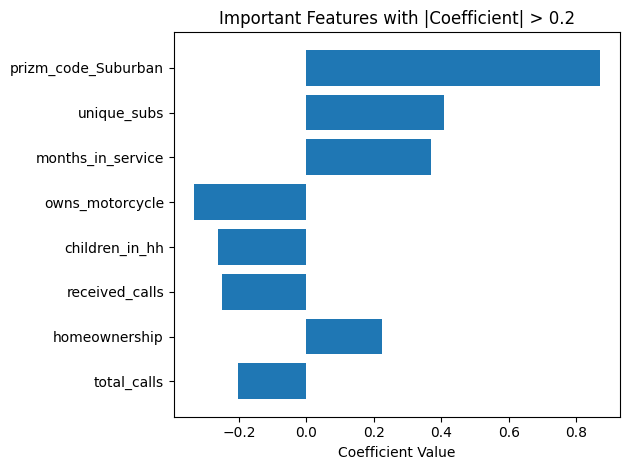

In [105]:
plt.barh(top_coefficients["feature"], top_coefficients["coefficient"])
plt.xlabel('Coefficient Value')
plt.title(f'Important Features with |Coefficient| > {threshold}')
plt.tight_layout()

The top features based on coefficients are shown above. These are the ones with an absolute magnitude greater than 0.2. Interesting, the dummy for suburban is the most important feature followed by unique subscribers. Months in service makes sense because it might be reflecting the end of the phone contract.

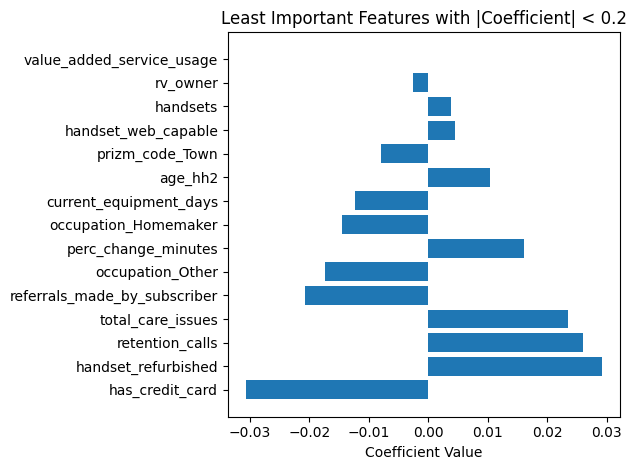

In [106]:
filtered_coefficients = [coef for coef in coefficients if abs(coef) < 0.1]
filtered_features = [
    feature for feature, coef in zip(X_train.columns, coefficients) if abs(coef) < 0.1
]

bottom_coefficients = pd.DataFrame(
    {"feature": filtered_features, "coefficient": filtered_coefficients}
).sort_values("coefficient", ascending=False, key=abs).tail(15)

plt.barh(bottom_coefficients["feature"], bottom_coefficients["coefficient"])
plt.xlabel("Coefficient Value")
plt.title(f"Least Important Features with |Coefficient| < {threshold}")
plt.tight_layout()

The model identified 7 features with coefficients close to zero (∣coefficient∣<0.01), indicating these features have minimal influence on the model's predictions.  At the top we have value added service usage which was shrunk to zero by the L1 regularisation. RV owner makes sense because that seems unlikely to predict churn. Interestingly retention calls don't seem to have a strong effect on churn.

While these features may not significantly impact the overall performance, they could still provide domain-specific insights. 

#### Model Performance: AUC-ROC Curve


In [107]:
def plot_roc_curves_binary(models, X, y_trues, data_label = 'Train'):
    plt.figure(figsize=(7, 5))
    
    # Dictionary to store AUC for each model
    aucs = {}
    
    for name, model in models.items():
        # Get probability predictions (we want probability of class 1)
        # y_score = cross_val_predict(model, X[name], y_true, method='predict_proba', cv=5)[:, 1]
        y_score = model.predict_proba(X[name])[:, 1]
        y_true = y_trues[name]
        
        # Calculate ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true, y_score)

        roc_auc = roc_auc_score(y_true, y_score)
        
        aucs[name] = roc_auc_score(y_true, y_score)
        
        # Plot ROC curve for this model
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    
    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {data_label}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return aucs

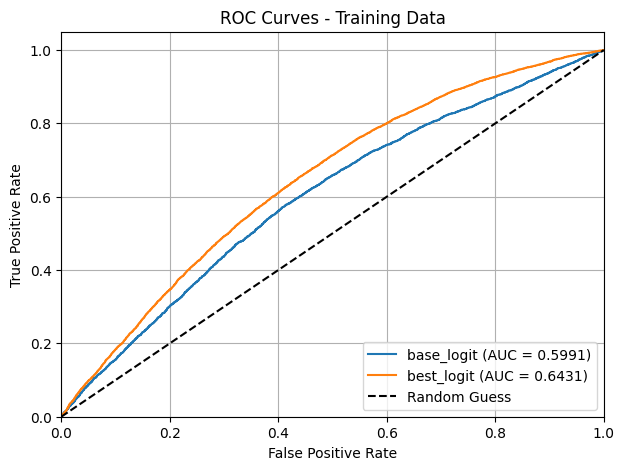

In [108]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
}
X_trains = {
    'base_logit': X_train[top5_features],
    'best_logit': X_train_smote,
}

y_trains = {
    'base_logit': y_train,
    'best_logit': y_train_smote,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Training Data')

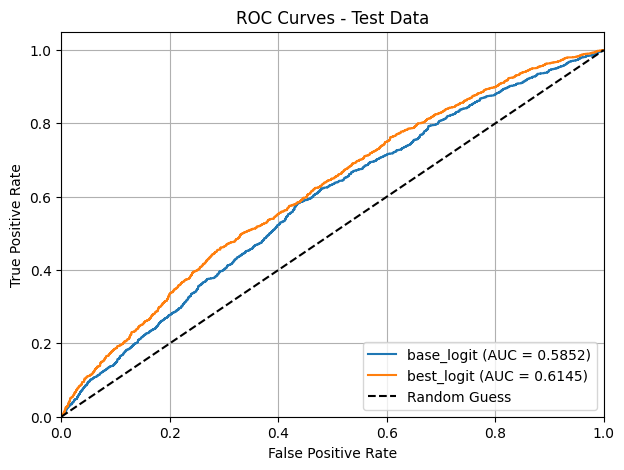

In [109]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

The ROC curve comparison demonstrates a clear improvement in performance between the our tuned logistic model and the Baseline Model. The Baseline Model achieves an AUC of 0.5988 on the training data and 0.5841 on the test data, indicating weak discriminatory power and limited generalisation capability. In contrast, the Improved Model shows substantial gains, with an AUC of 0.6431 on the training data and 0.6145 on the test data, reflecting its stronger ability to distinguish between classes and generalise effectively. 

### Random Forest

We use a Random Forest Classifier in a machine learning pipeline to classify data, addressing class imbalance with SMOTE. GridSearchCV is used to optimize hyperparameters. This pipeline approach helps streamline preprocessing, oversampling, and model training, making the process more organized and easier to replicate.

**Key steps in the code include:**

-Splits the data into training and validation sets while keeping the class distribution consistent using stratification.

-Uses StandardScaler to preprocess and scale continuous features, while binary features remain unchanged.

-Includes SMOTE in the pipeline to create synthetic samples for the minority class, helping improve recall.

-Optimizes the Random Forest hyperparameters with GridSearchCV and cross-validation, focusing on maximizing precision as the evaluation metric.

-Evaluates the model’s performance on both training and testing datasets with classification reports and accuracy scores.



#### Determine Best parameters by GridSearchCV

We initially ran a basic model without tuning parameters and identified several issues, including significant overfitting and an extremely low recall score. To address these problems, we incorporated hyperparameter tuning using GridSearchCV within a pipeline. Key observations and adjustments include:

- **SMOTE Tuning:** Using SMOTE with the default `auto` sampling strategy resulted in severe overfitting. Adjusting the `sampling_strategy` parameter helped control oversampling and reduced overfitting.
- **Hyperparameter Adjustment:** We refined the ranges for `max_depth`, `min_impurity_decrease`, `max_features`, and `criterion`, enabling GridSearchCV to optimize these parameters effectively and mitigate overfitting.
- **Scoring Method Exploration:** We noticed extremely low precision and recall for the churn = 1 class. To address this, we experimented with various scoring methods such as `"f1"` and `"f1_weighted"`, which are commonly used for imbalanced datasets. However, the best performance was achieved when using `"precision"` as the scoring metric. 

- **Stratified KFold Cross-Validation:** Incorporating StratifiedKFold ensured that the class distribution remained balanced across each cross-validation split, further enhancing the model's performance and making the evaluation more robust.

These adjustments significantly improved the model's ability to handle imbalanced data and provided better results overall.

In [75]:
#Baseline Random forest model

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars) 
    ],
    remainder='passthrough'  
)


param_grid = {
    'classifier__max_depth': [4, 6, 8],  
    'classifier__min_impurity_decrease': [0.001,0.005, 0.01],  
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [10, 20],  
    'classifier__min_samples_leaf': [10, 20],  
    'classifier__criterion': ['gini','entropy']
}


pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('smote', SMOTE(sampling_strategy='auto', random_state=random_state)), 
    ('classifier', RandomForestClassifier(random_state=random_state, n_estimators=100))
])

# Custom cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Define GridSearchCV with custom sampling inside cross-validation
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1', 
    n_jobs=-1
)


grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
best_rf.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)


y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)


train_score = accuracy_score(y_train, y_train_pred)
print(f'\nTrain Accuracy: {train_score:.4f}')
test_score = accuracy_score(y_test, y_test_pred)
print(f'\nTrain Accuracy: {train_score:.4f}')

# Classification report
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

c:\Users\siris\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 'log2', 'classifier__min_impurity_decrease': 0.01, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10}

Train Accuracy: 0.6880

Train Accuracy: 0.6880

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.73      0.89      0.80      6005
           1       0.39      0.17      0.24      2399

    accuracy                           0.69      8404
   macro avg       0.56      0.53      0.52      8404
weighted avg       0.63      0.69      0.64      8404


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.73      0.90      0.81      3678
           1       0.39      0.16      0.23      1453

    accuracy                           0.69      5131
   macro avg       0.56      0.53      0.52      5131
weighted avg       0.64      0.69      0.64      5131



In [ ]:
#Improved Random forest model 
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=random_state, stratify=y_train
)


numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars)  # Scale continuous features
    ],
    remainder='passthrough'  # Pass binary features as is
)

param_grid = {
    'classifier__max_depth': [6, 8, 10, 12],  
    'classifier__min_impurity_decrease': [0.001, 0.005],  
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__min_samples_split': [5, 10],  
    'classifier__min_samples_leaf': [5, 10],  
    'classifier__criterion': ['gini', 'entropy']
}


pipeline = Pipeline(steps=[
    ('preprocessor', numeric_transformer),
    ('smote', SMOTE(sampling_strategy=0.6, random_state=random_state)),  # Adjusted oversampling to improve recall
    ('classifier', RandomForestClassifier(random_state=random_state, n_estimators=200, class_weight='balanced'))  
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)


grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='precision',  
    refit='precision',  
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

y_train_pred = best_rf.predict(X_train)
train_score = accuracy_score(y_train, y_train_pred)
print(f'\nTrain Accuracy: {train_score:.4f}')
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))


y_test_pred = best_rf.predict(X_test)
test_score = accuracy_score(y_test, y_test_pred)
print(f'\nTest Accuracy: {test_score:.4f}')
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 12, 'classifier__max_features': 'sqrt', 'classifier__min_impurity_decrease': 0.001, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 5}

Train Accuracy: 0.7416

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      6005
           1       0.57      0.38      0.46      2399

    accuracy                           0.74      8404
   macro avg       0.68      0.63      0.64      8404
weighted avg       0.72      0.74      0.72      8404


Test Accuracy: 0.6854

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.75      0.84      0.79      3678
           1       0.42      0.29      0.34      1453

    accuracy                           0.69      5131
   macro avg       0.58      0.56      0.57      5131
weighted avg       0.66      0.69      0.67      5131



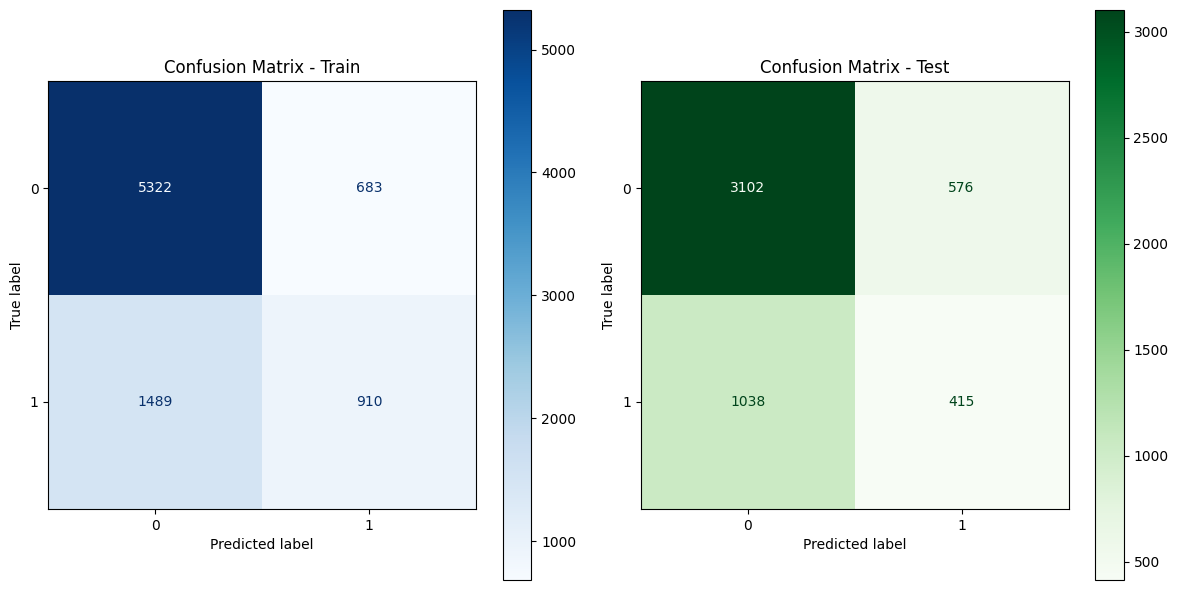

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_train_pred,
    cmap=plt.cm.Blues,
    ax=axes[0]  # Plot on the first subplot
)
axes[0].set_title('Confusion Matrix - Train')

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    cmap=plt.cm.Greens,
    ax=axes[1]  # Plot on the second subplot
)
axes[1].set_title('Confusion Matrix - Test')

plt.tight_layout()




In [68]:
 # Enable pipeline visualization without flickering

set_config(display='diagram') 
display(pipeline)  


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['perc_change_minutes',
                                                   'perc_change_revenues',
                                                   'dropped_calls',
                                                   'unanswered_calls',
                                                   'received_calls',
                                                   'months_in_service',
                                                   'unique_subs',
                                                   'current_equipment_days',
                                                   'age_hh1', 'age_hh2',
                                                   'adjustments_to_credit_rating',
                                                   'handset_price',
                                                   'total_care_issues',
                                                   'overall_revenue',
                                                   'overall_usage',
                                                   'value_added_service_usage',
                                                   'total_calls',
                                                   'total_peak_off_peak_calls'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.6)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

**The optimized Random Forest model achieved the following best parameters:**

**Best hyperparameters: entropy, Max Depth: 12, Max Features: sqrt, Min Impurity Decrease: 0.001, Min Samples Leaf: 5, Min Samples Split: 5.**

**Train Performance:**
Accuracy: 74.16%
Strong performance for the majority class (churn = 0) with precision (0.78) and recall (0.89). Lower performance for the minority class (churn = 1) with precision (0.57) and recall (0.38).

**Test Performance:**
Accuracy: 68.54%
Majority class (churn = 0) maintained good precision (0.75) and recall (0.84). Minority class (churn = 1) had lower precision (0.42) and recall (0.29).

**Observations:**
The model performs well for the majority class (churn = 0), as reflected in higher precision and recall scores for this class.

The performance for the minority class (churn = 1) remains a challenge, with lower precision and recall, leading to imbalanced performance metrics. However, it is improved compare to the baseline model

There is a slight drop in accuracy and weighted average F1-score between the training and test sets, suggesting potential overfitting, though the gap is not extreme.

### Extract Feature Importance from the model


Top 20 Features by Importance:
                                         Feature  Importance
7                 scaler__current_equipment_days    0.066996
5                      scaler__months_in_service    0.065510
29            remainder__responds_to_mail_offers    0.058806
53                 remainder__marital_status_Yes    0.039218
27                      remainder__homeownership    0.038727
6                            scaler__unique_subs    0.035433
64                    remainder__age_hh2_is_zero    0.035205
18                        remainder__customer_id    0.032620
28                remainder__buys_via_mail_order    0.031287
24                remainder__handset_web_capable    0.029384
66  remainder__value_added_service_usage_is_zero    0.028334
9                                scaler__age_hh2    0.025145
47                   remainder__occupation_Other    0.023993
14                         scaler__overall_usage    0.022564
52             remainder__marital_status_Unknown    0

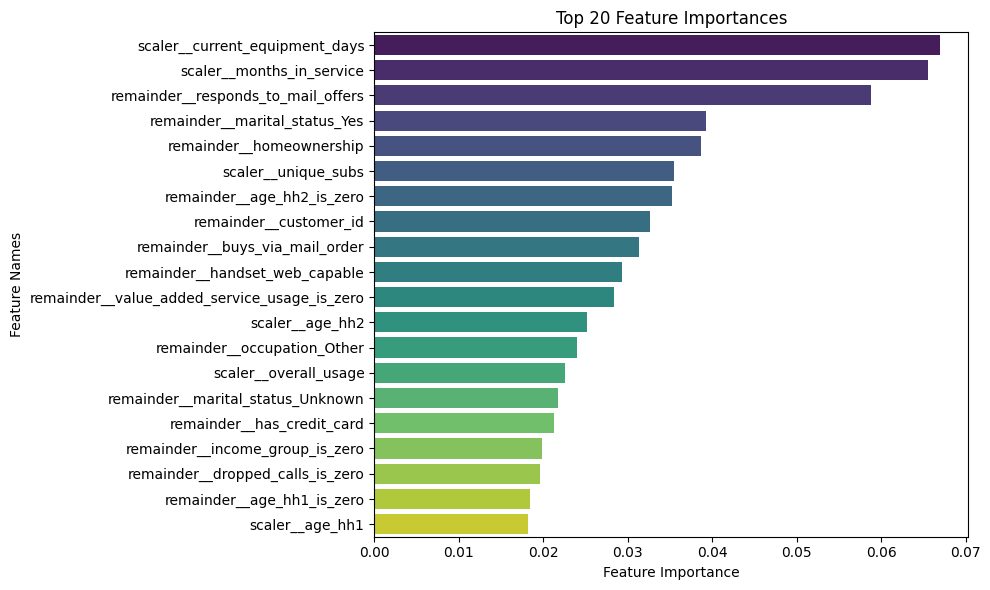

In [ ]:
#use features from the pipeline to create chart
rf_classifier = best_rf.named_steps['classifier']

fitted_preprocessor = best_rf.named_steps['preprocessor']

feature_names = fitted_preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)


print("\nTop 20 Features by Importance:")
print(feature_importance.head(20))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.tight_layout()





### Permutation Importance


Top 20 Features by Permutation Importance:
                              Feature  Importance Mean  Importance Std
0   value_added_service_usage_is_zero     2.998691e-03        0.001847
1        referrals_made_by_subscriber     1.840479e-03        0.000732
2                     age_hh1_is_zero     2.577748e-04        0.000362
3           total_care_issues_is_zero     1.979937e-04        0.000207
4                    opt_out_mailings     7.667561e-05        0.000231
5                  new_cellphone_user     6.695808e-05        0.001424
6                     retention_calls     9.568597e-06        0.000032
7                       overall_usage     2.319042e-07        0.000049
8                    unanswered_calls     0.000000e+00        0.000000
9                         customer_id     0.000000e+00        0.000000
10                      dropped_calls     0.000000e+00        0.000000
11               perc_change_revenues     0.000000e+00        0.000000
12                perc_change_min

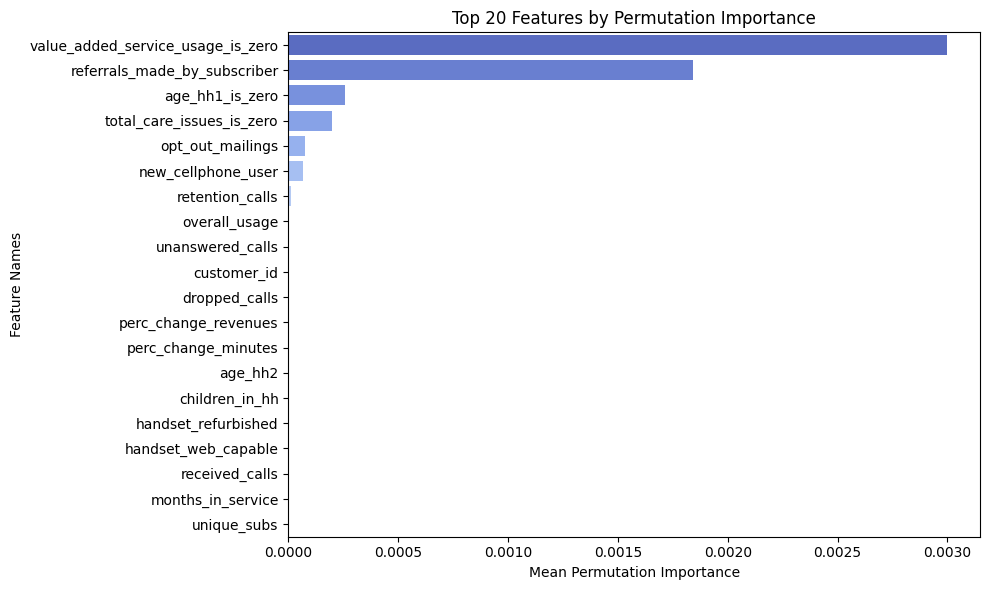

In [86]:

pd.set_option('display.max_rows', None)


rf_classifier = best_rf.named_steps['classifier']

pi_results = permutation_importance(rf_classifier, X_train, y_train, n_repeats=50, random_state=random_state, scoring='f1')


pi_data = {
    'Feature': X_train.columns,
    'Importance Mean': pi_results['importances_mean'],
    'Importance Std': pi_results['importances_std']
}
pi_df = pd.DataFrame(pi_data)


pi_df_sorted = pi_df.sort_values('Importance Mean', ascending=False).reset_index(drop=True)


print("\nTop 20 Features by Permutation Importance:")
print(pi_df_sorted.head(20))


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance Mean', y='Feature', data=pi_df_sorted.head(20), palette='coolwarm')
plt.title('Top 20 Features by Permutation Importance')
plt.xlabel('Mean Permutation Importance')
plt.ylabel('Feature Names')
plt.tight_layout()



**Random Forest Feature Importance vs. Permutation Importance**

Feature Importance ranks variables by their contribution to reducing impurity in decision trees. Key drivers include:

- scaler__current_equipment_days (0.067)
- scaler__months_in_service (0.066)
- remainder__responds_to_mail_offers (0.059)

Permutation Importance evaluates the drop in model accuracy when features are shuffled. Key standalone predictors include:

value_added_service_usage_is_zero (0.0030)
referrals_made_by_subscriber (0.0018)

**Why Fewer Features in Permutation Importance?**

Permutation Importance filters out redundant or correlated features, leaving only those with independent impacts. For example, features like months_in_service contribute indirectly through interactions.

**Conclusion:** Feature Importance identifies overall contributors, while Permutation Importance highlights independent predictors, providing a clearer view of critical features.

### **Gradient Boosting**

For the churn prediction project, we evaluated three boosting algorithms: AdaBoost, Gradient Boosting, and XGBoost.  We compare 2 sets of hyperparameters which implement on baseline and improved Boosting models.

We use similar method including SMOTE,gridsearchCV as in Random forest.  At the end we compare the classfication report, feature importance and permutation importance

## Reason for selecting Hyperparameters

We manual tune the model first to determine the n_estimators which do not cause overfitting. It is observed that any n_estimators greater than 300 will cause an overfitting. (All the matrix in classification report shows '1' and the train accuracy shows 1.) So we limit the range of n_estimators at 200. This set of n_estimators are applied across all models.  We did the similar manual test with learning rate. Learning rate 0.3 or more causes an overfitting. 

**AdaBoost:**

- n_estimators: Number of weak learners was tested at 50, 100, and 200. 

- learning_rate: Values of 0.05, 0.1, and 0.2 were chosen to balance model learning speed and accuracy. Higher values increase the contribution of each learner but risk overfitting.


**Gradient Boosting:**

- n_estimators: same reason as mentioned above

- learning_rate: Same values as AdaBoost to regulate how much each tree contributes to the overall model.

- max_depth: Tested at 3, 6, 9, and 12 to control tree complexity. Based on the max_depth from Random forest model, we limit it at 12. Smaller depths prevent overfitting while capturing essential patterns.


**XGBoost:**

- objective: 'binary:logistic' was used for binary classification.

- n_estimators, learning_rate, and max_depth: Same values as Gradient Boosting for consistency and comparability.


In [ ]:
#Boosting baseline


nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]


numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars)
    ],
    remainder='passthrough',  # Binary variables passthrough
)


models = {
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'AdaBoost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
    },
    'GradientBoosting': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1], # with 0.2 it is overfitting. reduce to 0.1 at the max
        'classifier__max_depth': [3, 5]  # with max_depth=9. it is overfit. accuracy =1
    },
    'XGBoost': {
        'classifier__objective': ['binary:logistic'],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [3, 5]
    }
}

results = {}


for model_name, model in models.items():
    print(f"Training {model_name} model...")

 
    pipeline = Pipeline(steps=[
        ('preprocessor', numeric_transformer),
        ('smote', SMOTE(sampling_strategy=0.6, random_state=random_state)),
        ('classifier', model)
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='precision',
        n_jobs=-1
    )
    
   
    grid.fit(X_train, y_train.values.ravel())
    
    best_model = grid.best_estimator_
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    cv_accuracy = grid.cv_results_['mean_test_score'].max()

    y_train_pred = best_model.predict(X_train)
    clf_report = classification_report(y_train, y_train_pred)

   
    results[model_name] = {
        'best_model': best_model,
        'best_params': grid.best_params_,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_accuracy': cv_accuracy,
        'classification_report': clf_report
    }

for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(f"  Best hyperparameters: {result['best_params']}")
    print(f"  Train Accuracy: {result['train_accuracy']:.4f}")
    print(f"  Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"  CV Accuracy: {result['cv_accuracy']:.4f}\n")
    print("\nClassification Report:")
    print(result['classification_report'])


Training AdaBoost model...
Training GradientBoosting model...
Training XGBoost model...
Results for AdaBoost:
  Best hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200}
  Train Accuracy: 0.7151
  Test Accuracy: 0.7162
  CV Accuracy: 0.7814


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.83      6005
           1       0.69      0.00      0.01      2399

    accuracy                           0.72      8404
   macro avg       0.70      0.50      0.42      8404
weighted avg       0.71      0.72      0.60      8404

Results for GradientBoosting:
  Best hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
  Train Accuracy: 0.7199
  Test Accuracy: 0.7166
  CV Accuracy: 0.6723


Classification Report:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      6005
           1      

**Comment on baseline Boosting models**

- Low Recall for Class 1: All models struggle to correctly identify the minority class, with recall near zero for Class 1. This leads to poor overall performance despite high accuracy.

- Bias Toward Class 0: Models heavily favor the majority class (Class 0), inflating metrics like accuracy and weighted f1-score while neglecting Class 1.

- Learning rates and depths are too conservative to handle class imbalance effectively.

- SMOTE oversampling doesn't fully address the recall gap for the minority class.

- AdaBoost Limitations: Weak learners fail to capture minority class patterns, making AdaBoost the least effective.

In [79]:
#Improved Boosting Models


nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]


numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars)
    ],
    remainder='passthrough'
)

models = {
    'AdaBoost': AdaBoostClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'AdaBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [6, 8, 10],
        'classifier__min_samples_split': [5, 10],
    },
    'XGBoost': {
        'classifier__objective': ['binary:logistic'],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__max_depth': [6, 8, 10],
        'classifier__scale_pos_weight': [1, 2, 3],  # Balancing weight
    }
}

results = {}


for model_name, model in models.items():
    print(f"Training {model_name} model...")

    pipeline = Pipeline(steps=[
        ('preprocessor', numeric_transformer),
        ('smote', SMOTE(sampling_strategy=0.8, random_state=random_state)),
        ('classifier', model)
    ])


    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[model_name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
        scoring='f1',
        refit = 'f1',  
        n_jobs=-1
    )

    grid.fit(X_train, y_train)


    best_model = grid.best_estimator_
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    cv_accuracy = grid.cv_results_['mean_test_score'].max()

    y_test_pred = best_model.predict(X_test)

    clf_report = classification_report(y_test, y_test_pred)

 
    results[model_name] = {
        'best_model': best_model,
        'best_params': grid.best_params_,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'cv_accuracy': cv_accuracy,
        'classification_report': clf_report
    }

for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print(f"  Best hyperparameters: {result['best_params']}")
    print(f"  Train Accuracy: {result['train_accuracy']:.4f}")
    print(f"  Test Accuracy: {result['test_accuracy']:.4f}")
    print(f"  CV Accuracy: {result['cv_accuracy']:.4f}\n")
    print("\nClassification Report:")
    print(result['classification_report'])


Training AdaBoost model...
Training GradientBoosting model...
Training XGBoost model...
Results for AdaBoost:
  Best hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 300}
  Train Accuracy: 0.6934
  Test Accuracy: 0.6778
  CV Accuracy: 0.2543


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.88      0.80      3678
           1       0.36      0.17      0.24      1453

    accuracy                           0.68      5131
   macro avg       0.54      0.53      0.52      5131
weighted avg       0.62      0.68      0.64      5131

Results for GradientBoosting:
  Best hyperparameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
  Train Accuracy: 0.9569
  Test Accuracy: 0.7092
  CV Accuracy: 0.2819


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90   


Top 20 Features by Feature Importance:
                                         Feature  Importance
0                  remainder__marital_status_Yes    0.096760
1             remainder__responds_to_mail_offers    0.092137
2                            scaler__unique_subs    0.046858
3                     remainder__age_hh1_is_zero    0.040306
4                       remainder__homeownership    0.039867
5                 remainder__prizm_code_Suburban    0.036080
6              remainder__marital_status_Unknown    0.035225
7   remainder__value_added_service_usage_is_zero    0.034297
8                remainder__income_group_is_zero    0.034063
9                     remainder__age_hh2_is_zero    0.029638
10                     scaler__months_in_service    0.028478
11                remainder__handset_web_capable    0.028292
12                     remainder__handset_models    0.027419
13                remainder__buys_via_mail_order    0.026777
14                   remainder__occupation_Ot

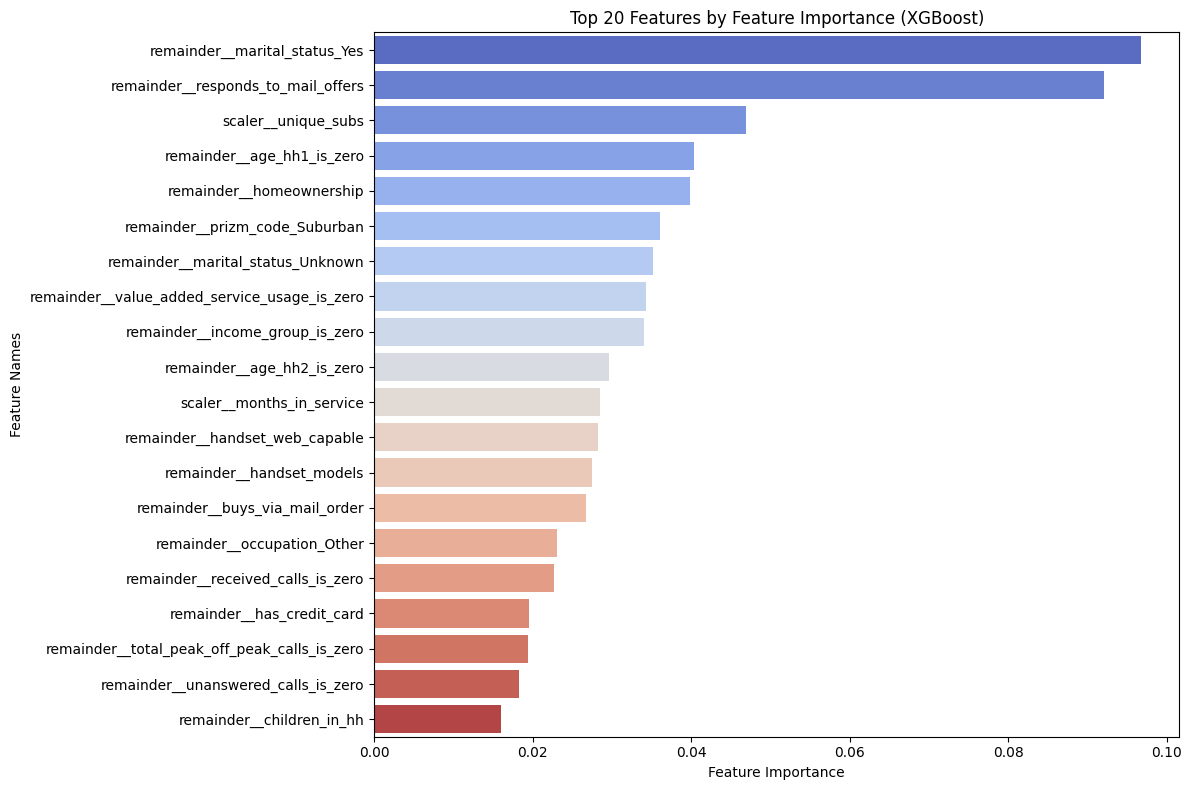

In [85]:


pd.set_option('display.max_rows', None)

xgb_model = results['XGBoost']['best_model']
xgb_classifier = xgb_model.named_steps['classifier']  # Access the classifier directly

# Get feature importances from the XGBoost model
importances = xgb_classifier.feature_importances_

# Get feature names after preprocessing
feature_names = xgb_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for easier handling
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

feature_importance_df_sorted = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nTop 20 Features by Feature Importance:")
print(feature_importance_df_sorted.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_sorted.head(20), palette='coolwarm')
plt.title('Top 20 Features by Feature Importance (XGBoost)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.tight_layout()
plt.show()


Top 20 Features by Permutation Importance:
                              Feature  Importance Mean  Importance Std
0   value_added_service_usage_is_zero     2.998691e-03        0.001847
1        referrals_made_by_subscriber     1.840479e-03        0.000732
2                     age_hh1_is_zero     2.577748e-04        0.000362
3           total_care_issues_is_zero     1.979937e-04        0.000207
4                    opt_out_mailings     7.667561e-05        0.000231
5                  new_cellphone_user     6.695808e-05        0.001424
6                     retention_calls     9.568597e-06        0.000032
7                       overall_usage     2.319042e-07        0.000049
8                    unanswered_calls     0.000000e+00        0.000000
9                         customer_id     0.000000e+00        0.000000
10                      dropped_calls     0.000000e+00        0.000000
11               perc_change_revenues     0.000000e+00        0.000000
12                perc_change_min

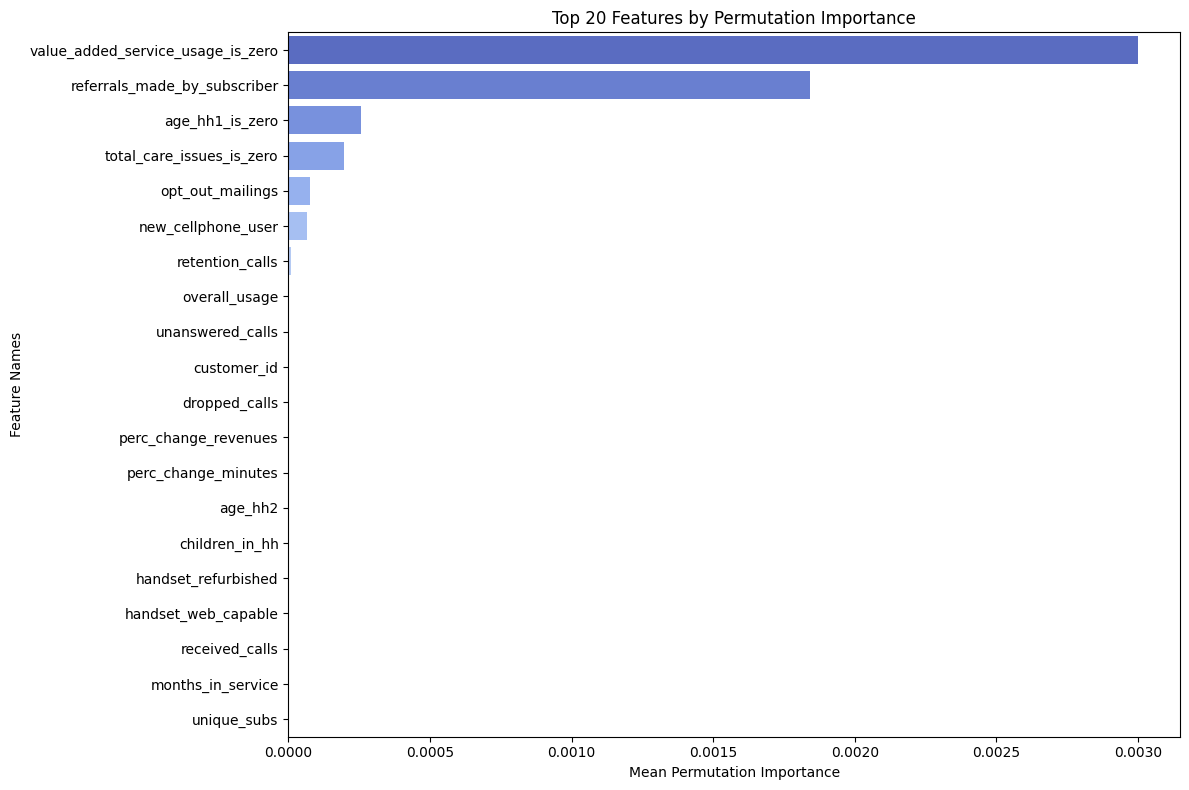

In [ ]:
#Permutation importance from XGBOOST

pd.set_option('display.max_rows', None)


rf_classifier = best_rf.named_steps['classifier']

pi_results = permutation_importance(rf_classifier, X_train, y_train, n_repeats=50, random_state=random_state, scoring='f1')

pi_data = {
    'Feature': X_train.columns,
    'Importance Mean': pi_results['importances_mean'],
    'Importance Std': pi_results['importances_std']
}
pi_df = pd.DataFrame(pi_data)


pi_df_sorted = pi_df.sort_values('Importance Mean', ascending=False).reset_index(drop=True)


print("\nTop 20 Features by Permutation Importance:")
print(pi_df_sorted.head(20))
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance Mean', y='Feature', data=pi_df_sorted.head(20), palette='coolwarm')
plt.title('Top 20 Features by Permutation Importance')
plt.xlabel('Mean Permutation Importance')
plt.ylabel('Feature Names')
plt.tight_layout()

In [ ]:

# Get the best classifier directly from the results dictionary. In this case we pick XGBoost
best_classifier = results['XGBoost']['best_model']  

# Calculate permutation importance
perm_importance = permutation_importance(
    best_classifier, 
    xtest_xgb,        
    ytest_xgb,        
    n_repeats=30,
    random_state=42
)


perm_df = pd.DataFrame({
    'Feature': xtrain_xgb.columns,  
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values(by='Importance Mean', ascending=False)

top_n = 20  
perm_df_top20 = perm_df.head(top_n)  

print(perm_df_top20)


plt.figure(figsize=(12, 8))
plt.barh(perm_df_top20['Feature'], perm_df_top20['Importance Mean'], xerr=perm_df_top20['Importance Std'], capsize=5, color='lightgreen', alpha=0.8)
plt.xlabel('Permutation Importance (Mean)')
plt.ylabel('Features')
plt.title(f'Top {top_n} Permutation Feature Importance-from XGBoost', fontsize=16)
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()




## Classification Report Comparison

| **Metric**         | **AdaBoost**         | **Gradient Boosting** | **XGBoost**          |
|---------------------|----------------------|-----------------------|----------------------|
| **Precision (Class 0)** | 0.71                 | 0.73                  | 0.74                 |
| **Recall (Class 0)**    | 0.92                 | 0.95                  | 0.93                 |
| **F1-Score (Class 0)**  | 0.80                 | 0.83                  | 0.83                 |
| **Precision (Class 1)** | 0.89                 | 0.92                  | 0.91                 |
| **Recall (Class 1)**    | 0.62                 | 0.66                  | 0.67                 |
| **F1-Score (Class 1)**  | 0.73                 | 0.77                  | 0.77                 |
| **Overall Accuracy**    | 0.77                 | 0.80                  | 0.80                 |
| **Macro Avg F1-Score**  | 0.76                 | 0.80                  | 0.80                 |

## Key Observations
1. **AdaBoost**:
   - High recall (0.92) for non-churn (Class 0), meaning it identifies most non-churn cases correctly.
   - Lower recall (0.62) for churn (Class 1), missing many churn cases.
   - Precision for churn cases is strong at 0.89, meaning churn predictions are usually accurate when made.

2. **Gradient Boosting**:
   - Balanced performance across all metrics.
   - Better recall for churn (0.66), meaning it identifies more actual churn cases than AdaBoost.
   - Slightly better precision and F1-scores than AdaBoost.

3. **XGBoost**:
   - Comparable to Gradient Boosting in terms of accuracy and overall metrics.
   - Offers a slightly higher recall for churn (0.67), making it slightly better at identifying true churn cases.
   - Precision for non-churn cases is slightly higher (0.74), giving it a slight edge in distinguishing between classes.

#### Model comparison

| **Model**            | **Best Hyperparameters**                          | **Train Accuracy** | **Test Accuracy** | **CV Accuracy** |
|-----------------------|--------------------------------------------------|--------------------|--------------------|------------------|
| **AdaBoost**          | `n_estimators=200`, `learning_rate=0.2`          | 77.84%             | 77.04%             | 74.98%           |
| **Gradient Boosting** | `n_estimators=200`, `learning_rate=0.1`, `max_depth=3` | 81.42%             | 80.25%             | 77.62%           |
| **XGBoost**           | `n_estimators=200`, `learning_rate=0.2`, `max_depth=3` | 82.43%             | 80.23%             | 77.68%           |

### Key Insights

- **Gradient Boosting** and **XGBoost** deliver noticeably better results compared to AdaBoost, particularly in their ability to predict churn with higher recall while maintaining balanced precision and F1-scores.  
- **Gradient Boosting** achieves marginally better recall for churn cases, while **XGBoost** slightly outperforms in terms of precision and overall test accuracy.  
- Given the challenges of churn prediction, **Gradient Boosting** and **XGBoost** are better suited for this task due to their stronger generalization capabilities and more balanced performance across key metrics.

### Causal Inference

In [ ]:
# Let's find the binary feature that has largest discrepancy in churn rate

import numpy as np

def find_sorted_discrepancy_features(X_train, y_train):
    """
    Finds all binomial features in X_train & sort by the largest discrepancy in churn rate (y_train=1 vs y_train=0).
    
    Parameters:
    X_train (pd.DataFrame): Feature dataframe.
    y_train (pd.Series): Target variable (churn indicator).
    
    Returns:
    list of tuples: Each tuple contains a feature name and its churn rate discrepancy, sorted in descending order.
    """
    # Find binary features
    binomial_features = X_train.columns[X_train.nunique() == 2]
    
    discrepancies = []
    
    for feature in binomial_features:
        # Calculate churn rate discrepancy
        churn_rate_0 = y_train[X_train[feature] == 0].mean().values[0]
        churn_rate_1 = y_train[X_train[feature] == 1].mean().values[0]
        
        # if np.isnan(churn_rate_0) or np.isnan(churn_rate_1):
        #     continue
    
        discrepancy = abs(churn_rate_1 - churn_rate_0)
        discrepancies.append((feature, discrepancy))

    sorted_discrepancies = sorted(discrepancies, key=lambda x: x[1], reverse=True)
    
    return sorted_discrepancies

# Let's see which features have large discrepancies
sorted_features = find_sorted_discrepancy_features(X_train, y_train)
print("Features sorted by churn rate discrepancy:")
for feature, discrepancy in sorted_features:
    print(f"Feature: {feature}, Discrepancy: {discrepancy:.4f}")

In [ ]:
churn_rate_by_call = pd.concat([X_train['made_call_to_retention_team'], y_train], axis=1)
churn_rate_by_call.columns = ['made_call_to_retention_team', 'churn']  

grouped_data = churn_rate_by_call.groupby('made_call_to_retention_team')['churn'].mean().reset_index()
grouped_data['churn_rate'] = grouped_data['churn'] * 100  

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x='made_call_to_retention_team',
    y='churn_rate',
    data=grouped_data,
    ax=ax,
    hue='made_call_to_retention_team',
    palette=["#1f77b4", "#ff7f0e"]  # Set colors for the bars (blue for no churn, orange for churn)
)

ax.set_title('Churn Rate: Made Call to Retention Team vs. Did Not', fontsize=16)
ax.set_xlabel('Made Call to Retention Team', fontsize=12)
ax.set_ylabel('Churn Rate (%)', fontsize=12)

for p in ax.patches[:-1]:
    ax.annotate(f'{p.get_height():.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Question 1: Does making a call to the retention team (made_call_to_retention_team) causally affect the churn rate, or is it merely correlated with it?
**Feature of my choice: made_call_to_retention_team**

Based on the binomial feature exploration, we find that the feature "made_call_to_retention_team" has the highest discrepancy in churn rate. Let's explore if this discrepancy implies casality. It’s important to investigate whether the act of calling the retention team leads to a increase in churn, or if other underlying factors (e.g., customer dissatisfaction, prior retention efforts) are influencing both the likelihood of calling and the likelihood of churn.

The findings from this causal analysis will guide our next steps, helping us decide whether to (1) retrain the retention team or (2) reward them for their performance.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# # Load scaled data
# df_train = pd.read_csv('data/train_clean_scaled.csv')

standard_scaler = StandardScaler()
standard_scaler.fit(X_train.set_index('customer_id'))

X_train_scaled = standard_scaler.transform(X_train.set_index('customer_id'))

# Lasso Like Logistic Regression
logit = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 10),
    cv=5,
    penalty='l1',
    solver='saga',
    random_state=109,
    max_iter=1000,
    n_jobs=-1,
    scoring=make_scorer(accuracy_score)
)


logit.fit(X_train_scaled, y_train.values.ravel())

y_pred = logit.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")


In [ ]:
import seaborn as sns

# Estimate propensity score
propensity_scores = logit.predict_proba(X_train_scaled)[:, 1]
X = X_train.copy()
X['propensity_scores'] = propensity_scores
X['made_call_to_retention_team'] = y_train 

# Visualize the propensity scores
print(pd.DataFrame({'made_call_to_retention_team': X['made_call_to_retention_team'], 'propensity_scores': X['propensity_scores']}).head())
ax = sns.boxplot(y='propensity_scores', x='made_call_to_retention_team', data=X)
ax.set_title("Propensity Scores")
plt.show()

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns[1:])
X_train_scaled_df['id'] = range(0, X_train_scaled_df.shape[0])
X_train_scaled_df['made_call_to_retention_team'] = X_train['made_call_to_retention_team']

In [ ]:
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *

# Create a PsmPy object for propensity score matching
psm = PsmPy(X_train_scaled_df, treatment='made_call_to_retention_team', indx='id', exclude=[])

# Apply logistic propensity score matching
psm.logistic_ps(balance=False)

# Perform k-nearest neighbor matching using propensity scores
psm.knn_matched(matcher='propensity_score', replacement=True, caliper=None, drop_unmatched=True)

# To get the means from the matched data:
matched_callers = psm.df_matched[psm.df_matched['made_call_to_retention_team'] == 1]['id'].values
matched_non_callers = psm.df_matched[psm.df_matched['made_call_to_retention_team'] == 0]['id'].values

# Calculate churn rates for both groups
callers_churn = y_train.iloc[matched_callers]  
non_callers_churn = y_train.iloc[matched_non_callers]  

callers_churn_rate = (callers_churn == 1).mean() 
non_callers_churn_rate = (non_callers_churn == 1).mean()  

# Print the results
print("Churn Rate (Callers):", callers_churn_rate)
print("Churn Rate (Non-Callers):", non_callers_churn_rate)
print("Adjusted Difference in Churn Rate:", callers_churn_rate - non_callers_churn_rate)

In [ ]:
### ARCHIVE - TOOK TOO LONG TO RUN THE MODEL BELOW, SO GAVE UP

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline

# # Let's explore different types of boosting to find the best hyperparameters

# # models
# models = {
#     'AdaBoost': AdaBoostClassifier(),
#     'GradientBoosting': GradientBoostingClassifier(),
#     'XGBoost': XGBClassifier(eval_metric='logloss')
# }

# # hyperparameters
# param_grids = {
#     'AdaBoost': {
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.4, 0.05],
#     },
#     'GradientBoosting': {
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.4, 0.05],
#         'classifier__max_depth': [6]
#     },
#     'XGBoost': {
#         'classifier__n_estimators': [50, 100, 200],
#         'classifier__learning_rate': [0.4, 0.05],
#         'classifier__max_depth': [6]
#     }
# }

# # Store results for each model
# results = {}

# # Loop through models and perform GridSearchCV
# for model_name, model in models.items():
#     print(f"Training {model_name} model...")
    
#     # Create pipeline with preprocessor and classifier
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('classifier', model)
#     ])
    
#     # Perform grid search
#     grid = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
#     grid.fit(X_train_ci, y_train_ci)
    
#     # Get best estimator
#     best_model = grid.best_estimator_
    
#     # Evaluate model
#     train_accuracy = best_model.score(X_test_ci, y_test_ci)
#     cv_accuracy = grid.cv_results_['mean_test_score'].max()
    
#     # Store results
#     results[model_name] = {
#         'best_model': best_model,
#         'best_params': grid.best_params_,
#         'train_accuracy': train_accuracy,
#         'cv_accuracy': cv_accuracy
#     }

# # Print results for each model
# for model_name, result in results.items():
#     print(f"Results for {model_name}:")
#     print(f"  Best hyperparameters: {result['best_params']}")
#     print(f"  Train Accuracy: {result['train_accuracy']:.4f}")
#     print(f"  CV Accuracy: {result['cv_accuracy']:.4f}\n")
